In [47]:
import pickle
import numpy as np

with open("./Datasets/Colombia/X_train.pkl", "rb") as archivo:
    ppg_array = pickle.load(archivo)

with open("./Datasets/Colombia/y_train.pkl", "rb") as archivo:
    labels = pickle.load(archivo)

print(f"✅ Shape de X_train: {ppg_array.shape}")
print(f"✅ Shape de Y_train: {labels.shape} (Distribución: {np.unique(labels, return_counts=True)})")

✅ Shape de X_train: (1170, 200)
✅ Shape de Y_train: (1170,) (Distribución: (array([False,  True]), array([741, 429])))


In [49]:
normal_indices = np.where(labels == True)[0]
pathology_indices = np.where(labels == False)[0]

In [110]:
ppg_signals = ppg_array[normal_indices]
tipo = "normotension"
#tipo = "patologia"

# Encoder VAE

In [115]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Lambda, Flatten, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import mixed_precision

# 🔹 Habilitar política de precisión mixta
mixed_precision.set_global_policy('float32')

# 🔹 Parámetros del modelo
num_samples = ppg_signals.shape[1]  # Número de muestras por señal
latent_dim = 512  # Dimensión del espacio latente ampliada
hidden_dim = num_samples  # Número de neuronas en capas ocultas

# 🔹 Encoder
def build_encoder():
    inputs = Input(shape=(num_samples,), name="encoder_input")
    x = Dense(hidden_dim, activation='relu', name="encoder_hidden_1")(inputs)
    x = Dense(hidden_dim // 2, activation='relu', name="encoder_hidden_2")(x)

    z_mean = Dense(latent_dim, name="z_mean", dtype="float32")(x)
    z_log_var = Dense(latent_dim, name="z_log_var", dtype="float32")(x)

    # Sampling Layer
    def sampling(args):
        z_mean, z_log_var = args
        epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0., stddev=1.5, dtype=z_mean.dtype)
        return z_mean + K.exp(0.5 * z_log_var) * epsilon

    z = Lambda(sampling, output_shape=(latent_dim,), name="z")([z_mean, z_log_var])
    return Model(inputs, [z_mean, z_log_var, z], name="Encoder")

# 🔹 Decoder
def build_decoder():
    decoder_inputs = Input(shape=(latent_dim,), name="decoder_input")
    x = Dense(hidden_dim // 2, activation='relu', name="decoder_hidden_1")(decoder_inputs)
    x = Dense(hidden_dim, activation='relu', name="decoder_hidden_2")(x)
    outputs = Dense(num_samples, activation='sigmoid', name="decoder_output")(x)
    return Model(decoder_inputs, outputs, name="Decoder")

# 🔹 Pérdida personalizada como capa
def vae_loss_layer(inputs, reconstructed, z_mean, z_log_var):
    reconstruction_loss = tf.reduce_mean(tf.square(inputs - reconstructed))  # Pérdida de reconstrucción
    kl_loss = -0.5 * tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=-1)  # Pérdida KL
    return reconstruction_loss + 0.001 * kl_loss  # Escalar KL para mayor diversidad

class VAELossLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(VAELossLayer, self).__init__(**kwargs)

    def call(self, inputs):
        inputs, reconstructed, z_mean, z_log_var = inputs
        loss = vae_loss_layer(inputs, reconstructed, z_mean, z_log_var)
        self.add_loss(loss)
        return reconstructed

# 🔹 Construir VAE
encoder = build_encoder()
decoder = build_decoder()

inputs = encoder.input
z_mean, z_log_var, z = encoder.output
reconstructed = decoder(z)

vae_outputs = VAELossLayer()([inputs, reconstructed, z_mean, z_log_var])
vae = Model(inputs, vae_outputs, name="VAE")
vae.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005))

# 🔹 Resumen de los modelos
encoder.summary()
decoder.summary()
vae.summary()

# 🔹 Entrenamiento del modelo
vae.fit(ppg_signals, ppg_signals, epochs=200, batch_size=64, verbose=1)

# 🔹 Generación de nuevas muestras
def generate_samples(decoder, n_samples=5, scale=2.0):
    z_samples = np.random.normal(size=(n_samples, latent_dim)) * scale
    generated = decoder.predict(z_samples)
    return np.clip(generated, 0, 1)  # Escalar señales generadas a [0, 1]



# Visualizar las señales generadas
def plot_generated_signals(synthetic_signals):
    plt.figure(figsize=(12, 6))
    for i, signal in enumerate(synthetic_signals):
        plt.plot(signal, label=f"Sintética {i+1}")
    plt.title("Señales Generadas con VAE")
    plt.legend()
    plt.grid()
    plt.show()



Model: "Encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ encoder_input             │ (None, 200)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ encoder_hidden_1 (Dense)  │ (None, 200)            │         40,200 │ encoder_input[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ encoder_hidden_2 (Dense)  │ (None, 100)            │         20,100 │ encoder_hidden_1[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z_mean (Dense)            │ (None, 512)            │         51,712 │ encoder_hidden_2[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z_log_var (Dense)         │ (None, 512)            │         51,712 │ encoder_hidden_2[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z (Lambda)                │ (None, 512)            │              0 │ z_mean[0][0],          │
│                           │                        │                │ z_log_var[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 163,724 (639.55 KB)

 Trainable params: 163,724 (639.55 KB)

 Non-trainable params: 0 (0.00 B)

Model: "Decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ decoder_input (InputLayer)           │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder_hidden_1 (Dense)             │ (None, 100)                 │          51,300 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder_hidden_2 (Dense)             │ (None, 200)                 │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder_output (Dense)               │ (None, 200)                 │          40,200 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 111,700 (436.33 KB)

 Trainable params: 111,700 (436.33 KB)

 Non-trainable params: 0 (0.00 B)

Model: "VAE"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ encoder_input             │ (None, 200)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ encoder_hidden_1 (Dense)  │ (None, 200)            │         40,200 │ encoder_input[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ encoder_hidden_2 (Dense)  │ (None, 100)            │         20,100 │ encoder_hidden_1[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z_mean (Dense)            │ (None, 512)            │         51,712 │ encoder_hidden_2[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z_log_var (Dense)         │ (None, 512)            │         51,712 │ encoder_hidden_2[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z (Lambda)                │ (None, 512)            │              0 │ z_mean[0][0],          │
│                           │                        │                │ z_log_var[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Decoder (Functional)      │ (None, 200)            │        111,700 │ z[0][0]                │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ vae_loss_layer_27         │ (None, 200)            │              0 │ encoder_input[0][0],   │
│ (VAELossLayer)            │                        │                │ Decoder[0][0],         │
│                           │                        │                │ z_mean[0][0],          │
│                           │                        │                │ z_log_var[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 275,424 (1.05 MB)

 Trainable params: 275,424 (1.05 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 225ms/step - loss: 6.1583
Epoch 2/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.9847 
Epoch 3/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.6764 
Epoch 4/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.6142 
Epoch 5/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.5002 
Epoch 6/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.3953 
Epoch 7/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.3953 
Epoch 8/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.3390 
Epoch 9/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.2819 
Epoch 10/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.2977 
Epoch 11/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.2699 
Epoch 12/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.3061 
Epoch 13/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.2638 
Epoch 14/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.3623 
Epoch 15/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - lo

In [116]:
# Guardar el encoder y decoder
encoder.save(f"./Modelos/modelo_vae/vae_encoder_{tipo}.keras")
decoder.save(f"./Modelos/modelo_vae/vae_decoder_{tipo}.keras")

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


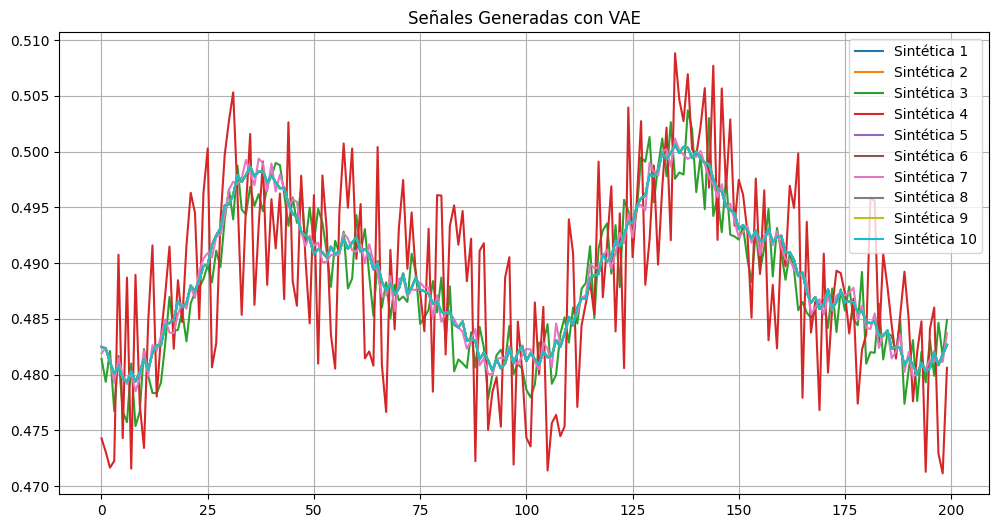

In [120]:

# Generar nuevas señales
synthetic_signals = generate_samples(decoder, n_samples=10)


plot_generated_signals(synthetic_signals)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


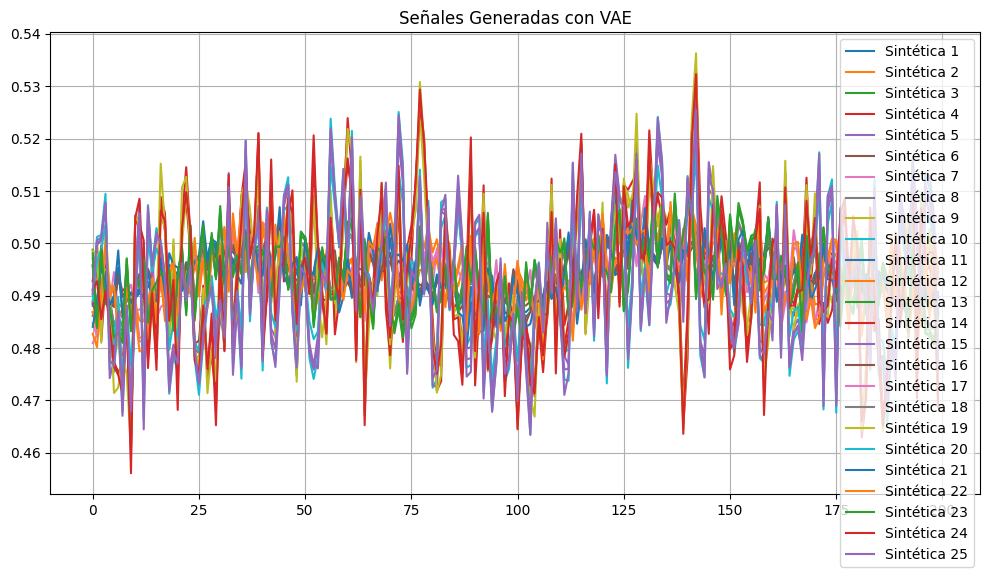

In [114]:
z_samples = np.random.normal(size=(5, latent_dim))  # Generar 5 muestras base
variations = [z_samples + np.random.normal(scale=0.1, size=z_samples.shape) for _ in range(5)]
synthetic_signals = np.vstack([decoder.predict(var) for var in variations])
plot_generated_signals(synthetic_signals)


# GAN

Epoch 0: D Loss = -0.33154296875, G Loss = -0.0020122528076171875
Epoch 500: D Loss = -2.1328125, G Loss = -11.046875
Epoch 1000: D Loss = 1.046875, G Loss = -9.671875
Epoch 1500: D Loss = 1.18359375, G Loss = -8.3125
Epoch 2000: D Loss = 0.2578125, G Loss = -9.234375
Epoch 2500: D Loss = 1.869140625, G Loss = -5.5
Epoch 3000: D Loss = -0.984375, G Loss = -4.15234375
Epoch 3500: D Loss = -0.1171875, G Loss = -8.34375
Epoch 4000: D Loss = 1.44140625, G Loss = -9.1484375
Epoch 4500: D Loss = 0.24609375, G Loss = -7.234375
Epoch 5000: D Loss = -1.4765625, G Loss = -10.5390625
Epoch 5500: D Loss = 1.6875, G Loss = -13.1484375
Epoch 6000: D Loss = 3.671875, G Loss = -10.203125
Epoch 6500: D Loss = -1.0, G Loss = -10.5546875
Epoch 7000: D Loss = -0.40625, G Loss = -10.265625
Epoch 7500: D Loss = 2.203125, G Loss = -12.484375
Epoch 8000: D Loss = 1.3671875, G Loss = -13.8515625
Epoch 8500: D Loss = -1.8046875, G Loss = -12.7578125
Epoch 9000: D Loss = -2.9765625, G Loss = -9.4609375
Epoch 950

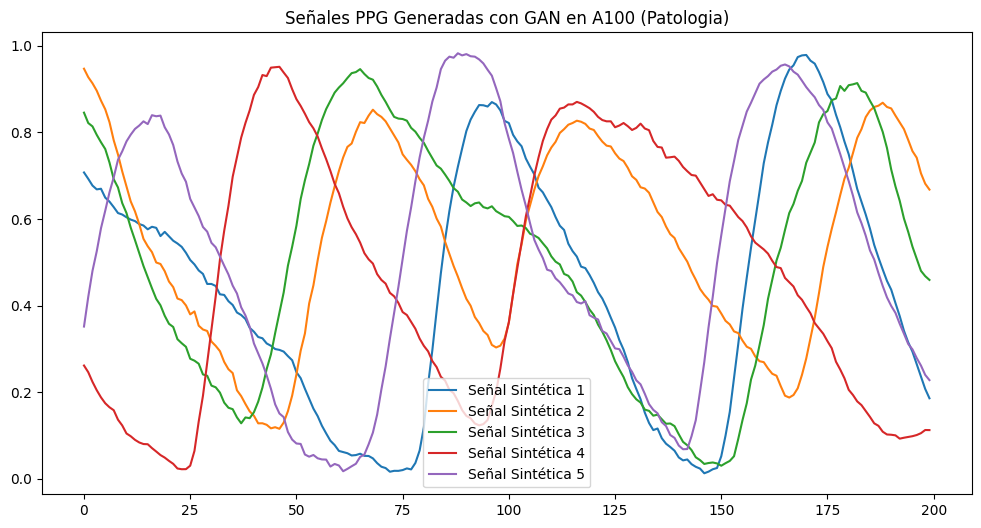

In [ ]:
## v4
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Dense, LeakyReLU, BatchNormalization, Reshape, Flatten, Dropout,
    Conv1D, Conv1DTranspose, Add
)
import matplotlib.pyplot as plt
import os
from tensorflow.keras import mixed_precision

# 🔹 Habilitar precisión mixta para la A100
mixed_precision.set_global_policy('mixed_float16')

# 📌 Parámetros
num_samples = ppg_signals.shape[1]
latent_dim = 64
batch_size = 128
epochs = 10000

# 🔹 Función para crear bloques residuales con ajuste de dimensiones
def residual_block(x, filters):
    shortcut = x
    x = Conv1D(filters, kernel_size=3, padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = Conv1D(filters, kernel_size=3, padding='same', activation='relu')(x)
    x = BatchNormalization()(x)

    # 🔹 Si el número de canales no coincide, ajustamos `shortcut`
    if shortcut.shape[-1] != filters:
        shortcut = Conv1D(filters, kernel_size=1, padding='same')(shortcut)

    x = Add()([x, shortcut])
    return x

# 🔹 Generador mejorado con ajustes de tamaño
def build_generator():
    inputs = Input(shape=(latent_dim,))
    x = Dense(num_samples // 4 * 64, activation='relu')(inputs)
    x = Reshape((num_samples // 4, 64))(x)

    # 🔥 Bloques Residuales con ajuste de dimensiones
    x = residual_block(x, 64)
    x = residual_block(x, 64)

    # 🔹 Upsampling convolucional
    x = Conv1DTranspose(64, kernel_size=3, strides=2, padding="same", activation='relu')(x)
    x = BatchNormalization()(x)
    x = Conv1DTranspose(1, kernel_size=3, strides=2, padding="same", activation='sigmoid')(x)

    return Model(inputs, x, name="Generator")

# 🔹 Discriminador corregido
def build_discriminator():
    inputs = Input(shape=(num_samples, 1))
    x = Conv1D(64, kernel_size=3, strides=2, padding="same", activation=LeakyReLU(0.2))(inputs)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)

    x = Conv1D(128, kernel_size=3, strides=2, padding="same", activation=LeakyReLU(0.2))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)

    x = Flatten()(x)
    x = Dense(1)(x)

    return Model(inputs, x, name="Discriminator")

# 🔹 Inicializar modelos
generator = build_generator()
discriminator = build_discriminator()

# 🔹 Optimización
optimizer_g = tf.keras.optimizers.Adam(0.00005, 0.5)
optimizer_d = tf.keras.optimizers.Adam(0.0001, 0.5)

# 📌 `@tf.function()` para aceleración en GPU
@tf.function
def train_step(real_samples):
    noise = tf.random.normal([batch_size, latent_dim])

    with tf.GradientTape() as tape_g, tf.GradientTape() as tape_d:
        fake_samples = generator(noise, training=True)
        real_pred = discriminator(real_samples, training=True)
        fake_pred = discriminator(fake_samples, training=True)

        d_loss = tf.reduce_mean(fake_pred) - tf.reduce_mean(real_pred)
        g_loss = -tf.reduce_mean(fake_pred)

    gradients_g = tape_g.gradient(g_loss, generator.trainable_variables)
    gradients_d = tape_d.gradient(d_loss, discriminator.trainable_variables)

    optimizer_g.apply_gradients(zip(gradients_g, generator.trainable_variables))
    optimizer_d.apply_gradients(zip(gradients_d, discriminator.trainable_variables))

    return g_loss, d_loss

# 📌 **Entrenamiento de la GAN**
def train_gan(epochs=10000, batch_size=128):
    X_real = ppg_signals.reshape(-1, num_samples, 1)
    dataset = tf.data.Dataset.from_tensor_slices(X_real).shuffle(10000).batch(batch_size).prefetch(tf.data.AUTOTUNE)

    for epoch in range(epochs):
        for real_samples in dataset:
            g_loss, d_loss = train_step(real_samples)

        # 📌 Guardar cada 500 épocas
        if epoch % 500 == 0:
            print(f"Epoch {epoch}: D Loss = {d_loss.numpy()}, G Loss = {g_loss.numpy()}")


# 📌 Definir directorio de logs de TensorBoard
log_dir = "logs/GAN"  # Directorio para TensorBoard
summary_writer = tf.summary.create_file_writer(log_dir)

train_gan(epochs=10000, batch_size=batch_size)

# 📌 **Generar señales PPG sintéticas**
def generate_synthetic_ppg_gan(num_samples=5):
    noise = np.random.normal(0, 1, (num_samples, latent_dim))
    gen_signals = generator.predict(noise, verbose=0)
    return gen_signals.reshape(num_samples, -1)

# 📌 **Visualización de señales generadas**
synthetic_ppg_signals = generate_synthetic_ppg_gan(5)

plt.figure(figsize=(12, 6))
for i in range(5):
    plt.plot(synthetic_ppg_signals[i], label=f"Señal Sintética {i+1}")
plt.legend()
plt.title("Señales PPG Generadas con GAN en A100")
plt.show()

In [ ]:
# 📌 Guardar el modelo del generador en formato TensorFlow
generator.save(f"/content/drive/MyDrive/Master Ingenieria de Telecomunicaciones/TFM/Producto_TFM/Modelos/modelo_gan/Generador PPG {tipo}.keras")
# 📌 Guardar solo los pesos del generador
generator.save_weights(f"/content/drive/MyDrive/Master Ingenieria de Telecomunicaciones/TFM/Producto_TFM/Modelos/modelo_gan/Generador PPG {tipo}.weights.h5")


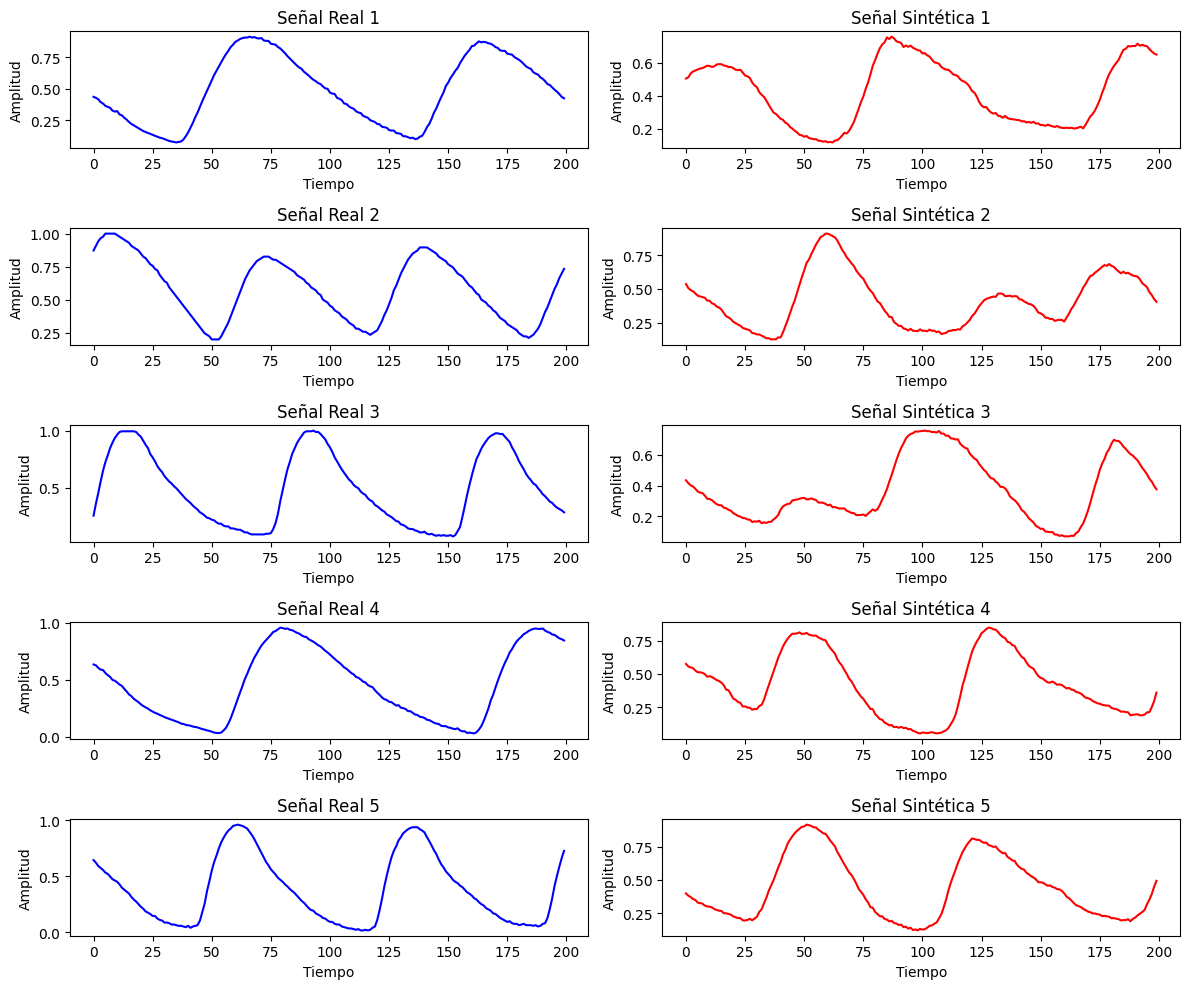

In [ ]:
import matplotlib.pyplot as plt

def plot_real_vs_synthetic(ppg_signals, synthetic_signals, num_samples=5):
    """
    Grafica señales originales y sintéticas en pares para compararlas visualmente.

    Parámetros:
    - ppg_signals: np.array -> Señales originales (shape: [N, 200])
    - synthetic_signals: np.array -> Señales sintéticas generadas por la GAN (shape: [N, 200])
    - num_samples: int -> Número de señales a comparar

    """
    # Seleccionamos aleatoriamente señales reales
    real_samples = ppg_signals[np.random.choice(ppg_signals.shape[0], num_samples, replace=False)]

    plt.figure(figsize=(12, num_samples * 2))

    for i in range(num_samples):
        plt.subplot(num_samples, 2, 2 * i + 1)
        plt.plot(real_samples[i], label="Real", color="blue")
        plt.title(f"Señal Real {i+1}")
        plt.xlabel("Tiempo")
        plt.ylabel("Amplitud")

        plt.subplot(num_samples, 2, 2 * i + 2)
        plt.plot(synthetic_signals[i], label="Sintética", color="red")
        plt.title(f"Señal Sintética {i+1}")
        plt.xlabel("Tiempo")
        plt.ylabel("Amplitud")

    plt.tight_layout()
    plt.show()

# 📌 **Ejemplo de uso con señales generadas**
synthetic_ppg_signals = generate_synthetic_ppg_gan(num_samples=100)
plot_real_vs_synthetic(ppg_signals, synthetic_ppg_signals, num_samples=5)

# WGAN - GP

In [ ]:
###################################################                       V1
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Dense, LeakyReLU, Reshape, Flatten, Dropout,
    Conv1D, Conv1DTranspose, Add, LayerNormalization,
    LSTM, Bidirectional, MultiHeadAttention
)
import matplotlib.pyplot as plt
from tensorflow.keras import mixed_precision



# 🔹 Bloque Residual con Normalización Espectral
def residual_block(x, filters):
    shortcut = x
    x = Conv1D(filters, kernel_size=3, padding='same', activation='relu')(x)
    x = LayerNormalization()(x)
    x = Conv1D(filters, kernel_size=3, padding='same', activation='relu')(x)
    x = LayerNormalization()(x)

    if shortcut.shape[-1] != filters:
        shortcut = Conv1D(filters, kernel_size=1, padding='same')(shortcut)

    x = Add()([x, shortcut])
    return x

# 🔹 Generador con LSTM y Self-Attention
def build_generator():
    inputs = Input(shape=(latent_dim,))
    x = Dense(num_samples // 4 * 64, activation='relu')(inputs)
    x = Reshape((num_samples // 4, 64))(x)

    # 🔥 Bloques Residuales + LSTM + Self-Attention
    x = residual_block(x, 64)
    x = Bidirectional(LSTM(64, return_sequences=True))(x)
    x = MultiHeadAttention(num_heads=4, key_dim=16)(x, x)
    x = residual_block(x, 64)

    # 🔹 Upsampling convolucional
    x = Conv1DTranspose(64, kernel_size=3, strides=2, padding="same", activation='relu')(x)
    x = Conv1DTranspose(1, kernel_size=3, strides=2, padding="same", activation='tanh')(x)

    return Model(inputs, x, name="Generator")

# 🔹 Discriminador con Normalización Espectral
def build_discriminator():
    inputs = Input(shape=(num_samples, 1))
    x = Conv1D(64, kernel_size=3, strides=2, padding="same")(inputs)
    x = LeakyReLU(0.2)(x)
    x = LayerNormalization()(x)
    x = Dropout(0.3)(x)

    x = Conv1D(128, kernel_size=3, strides=2, padding="same")(x)
    x = LeakyReLU(0.2)(x)
    x = LayerNormalization()(x)
    x = Dropout(0.3)(x)

    x = Flatten()(x)
    x = Dense(1)(x)

    return Model(inputs, x, name="Discriminator")

# 🔹 Penalización de gradiente para WGAN-GP
def gradient_penalty(discriminator, real_samples, fake_samples):
    batch_size = tf.shape(real_samples)[0]
    fake_samples = fake_samples[:batch_size]

    real_samples = tf.cast(real_samples, tf.float32)
    fake_samples = tf.cast(fake_samples, tf.float32)

    alpha = tf.random.uniform([batch_size, 1, 1], 0.0, 1.0, dtype=tf.float32)
    interpolates = alpha * real_samples + (1.0 - alpha) * fake_samples

    with tf.GradientTape() as tape:
        tape.watch(interpolates)
        pred = discriminator(interpolates, training=True)

    gradients = tape.gradient(pred, interpolates)
    norm = tf.sqrt(tf.reduce_sum(tf.square(gradients), axis=[1, 2]) + 1e-10)
    gp = tf.reduce_mean((norm - 1.0) ** 2)

    return gp



# 📌 `@tf.function()` para optimización en GPU
@tf.function
def train_step(real_samples):
    noise = tf.random.normal([batch_size, latent_dim])

    gp_weight = 7                 ######################################################################################

    for _ in range(n_critic):  # 🔹 Entrenar `D` varias veces antes de `G`
        with tf.GradientTape() as tape_d:
            fake_samples = generator(noise, training=True)
            real_pred = discriminator(real_samples, training=True)
            fake_pred = discriminator(fake_samples, training=True)

            gp = gradient_penalty(discriminator, real_samples, fake_samples)

            # 🔹 Convertir todo a float32 antes de operar
            real_pred = tf.cast(real_pred, tf.float32)
            fake_pred = tf.cast(fake_pred, tf.float32)
            gp = tf.cast(gp, tf.float32)

            d_loss = tf.reduce_mean(fake_pred) - tf.reduce_mean(real_pred) + gp_weight * gp

        gradients_d = tape_d.gradient(d_loss, discriminator.trainable_variables)
        optimizer_d.apply_gradients(zip(gradients_d, discriminator.trainable_variables))

    # 🔹 Entrenar `G` después de `n_critic` pasos
    with tf.GradientTape() as tape_g:
        fake_samples = generator(noise, training=True)
        fake_pred = discriminator(fake_samples, training=True)

        fake_pred = tf.cast(fake_pred, tf.float32)
        g_loss = -tf.reduce_mean(fake_pred)

    gradients_g = tape_g.gradient(g_loss, generator.trainable_variables)
    optimizer_g.apply_gradients(zip(gradients_g, generator.trainable_variables))

    return g_loss, d_loss



# 📌 **Entrenamiento de WGAN-GP Mejorado**
def train_wgan_gp(epochs=10000, batch_size=128):
    X_real = ppg_signals.reshape(-1, num_samples, 1)
    dataset = tf.data.Dataset.from_tensor_slices(X_real).shuffle(10000).batch(batch_size, drop_remainder=True).prefetch(tf.data.AUTOTUNE)

    g_losses, d_losses = [], []

    for epoch in range(epochs):
        for real_samples in dataset:
            g_loss, d_loss = train_step(real_samples)

        g_losses.append(g_loss.numpy())
        d_losses.append(d_loss.numpy())

        # 📌 Guardar logs en TensorBoard cada 100 epochs
        if epoch % 100 == 0:
            with tf.summary.create_file_writer(log_dir).as_default():
                tf.summary.scalar('Discriminator Loss', d_loss, step=epoch)
                tf.summary.scalar('Generator Loss', g_loss, step=epoch)

        # 📌 Guardar modelo cada 1000 épocas
        if epoch % 1000 == 0:
            generator.save(f"generator_epoch_{epoch}.keras")
            discriminator.save(f"discriminator_epoch_{epoch}.keras")
            synthetic_ppg_signals = generate_synthetic_ppg_wgan(2)
            # 📌 **Visualización de señales generadas**
            plt.figure(figsize=(12, 6))
            for i in range(2):
                plt.plot(synthetic_ppg_signals[i], label=f"Señal Sintética {i+1}")

            plt.legend()
            plt.title(f"Señales PPG Generadas con WGAN-GP + LSTM + Self-Attention en epoch: {epoch}")
            plt.xlabel("Tiempo (muestras)")
            plt.ylabel("Amplitud")
            plt.show()

        # 📌 Imprimir logs cada 500 épocas
        if epoch % 500 == 0:
            print(f"Epoch {epoch}: D Loss = {d_loss.numpy()}, G Loss = {g_loss.numpy()}")

    # 📌 📊 Graficar pérdidas al finalizar el entrenamiento
    plt.figure(figsize=(10, 5))
    plt.plot(g_losses, label="Generator Loss", color='blue')
    plt.plot(d_losses, label="Discriminator Loss", color='orange')

    # 📌 Configuración de la gráfica
    plt.xlabel("Épocas")
    plt.ylabel("Loss")
    plt.title("Evolución de las pérdidas del Generador y Discriminador")
    plt.legend()
    plt.grid()

    # 📌 Guardar la imagen de la gráfica
    #plt.savefig("training_loss_plot.png", dpi=300)

    # 📌 Mostrar la gráfica
    plt.show()


# 📌 **Función para generar señales PPG sintéticas**
def generate_synthetic_ppg_wgan(num_samples=5):
    noise = np.random.normal(0, 1, (num_samples, latent_dim))  # Generar ruido aleatorio
    gen_signals = generator.predict(noise, verbose=0)  # Generar señales con el generador entrenado
    return gen_signals.reshape(num_samples, -1)  # Devolver en forma adecuada



In [ ]:
# 🔹 Habilitar precisión mixta en GPU A100
mixed_precision.set_global_policy('mixed_float16')

# 📌 Parámetros
num_samples = ppg_signals.shape[1]  # Longitud de la señal PPG
latent_dim = 64
batch_size = 128
epochs = 10000
gp_weight = 10  #MODIFICAR TAMBIEN EN TRAIN_STEP # 🔹 Ajustado para estabilidad
n_critic = 5  # 🔹 Número de actualizaciones de `D` antes de `G`

# 🔹 Inicializar modelos
generator = build_generator()
discriminator = build_discriminator()

# 🔹 Optimizadores de WGAN-GP
optimizer_g = tf.keras.optimizers.Adam(learning_rate=0.00005, beta_1=0.5, beta_2=0.9)
optimizer_d = tf.keras.optimizers.Adam(learning_rate=0.00005, beta_1=0.5, beta_2=0.9)

# 📌 Definir directorio de logs de TensorBoard
log_dir = "logs/WGAN_GP"  # Directorio para TensorBoard
summary_writer = tf.summary.create_file_writer(log_dir)

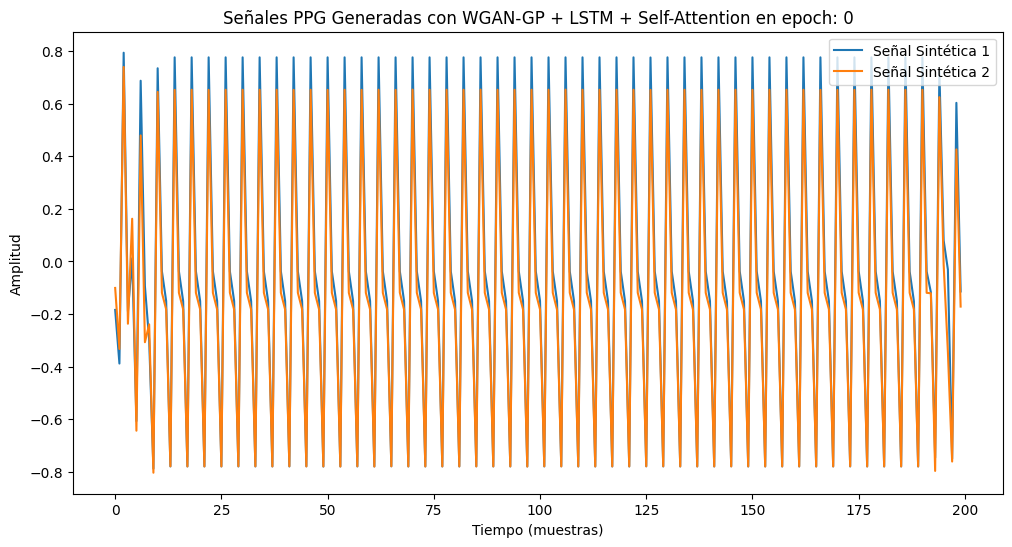

Epoch 0: D Loss = 125.4095687866211, G Loss = -1.1756916046142578
Epoch 500: D Loss = -2.990572214126587, G Loss = 6.889007568359375


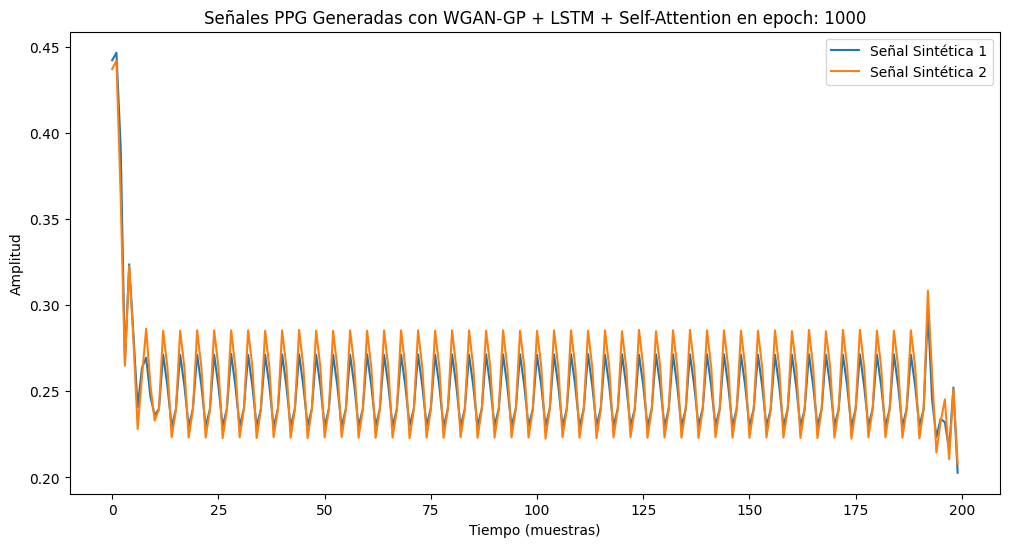

Epoch 1000: D Loss = -3.951777696609497, G Loss = 9.9881591796875
Epoch 1500: D Loss = -4.2512664794921875, G Loss = 10.36871337890625


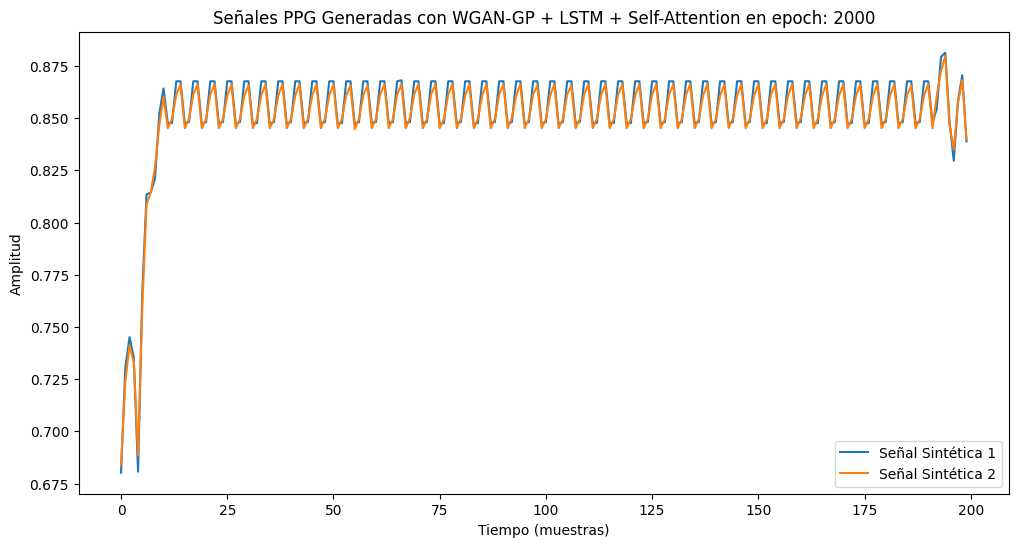

Epoch 2000: D Loss = -0.37522774934768677, G Loss = -3.0123977661132812
Epoch 2500: D Loss = -0.7352854609489441, G Loss = -12.42449951171875


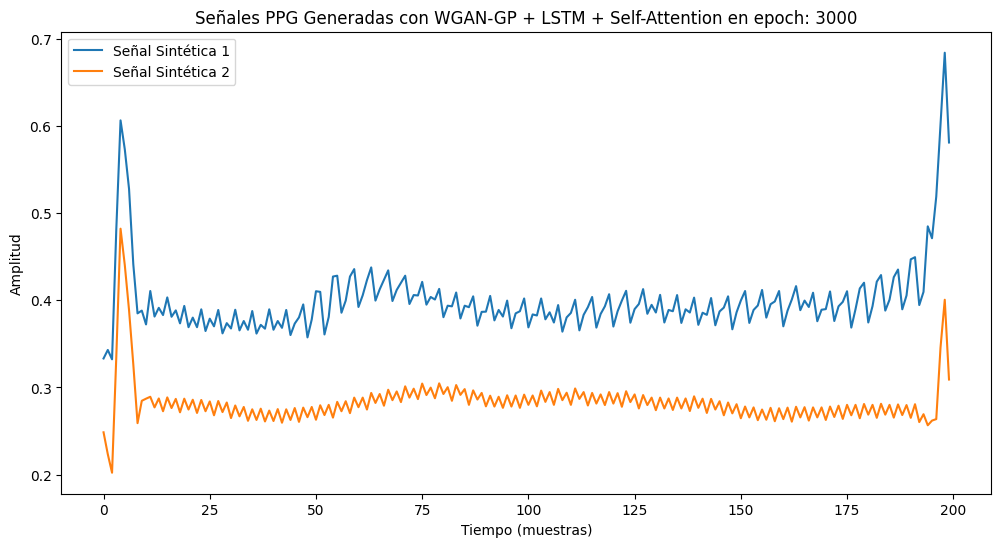

Epoch 3000: D Loss = -0.12128735333681107, G Loss = -9.51654052734375
Epoch 3500: D Loss = -0.27902597188949585, G Loss = -10.792633056640625


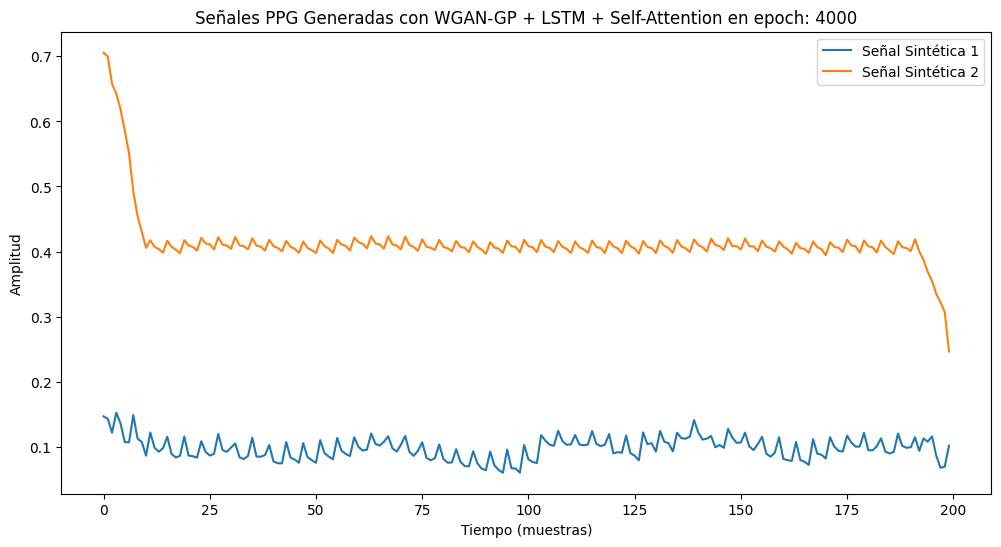

Epoch 4000: D Loss = 0.12973348796367645, G Loss = -9.314971923828125
Epoch 4500: D Loss = -0.0003743171691894531, G Loss = -5.417486667633057


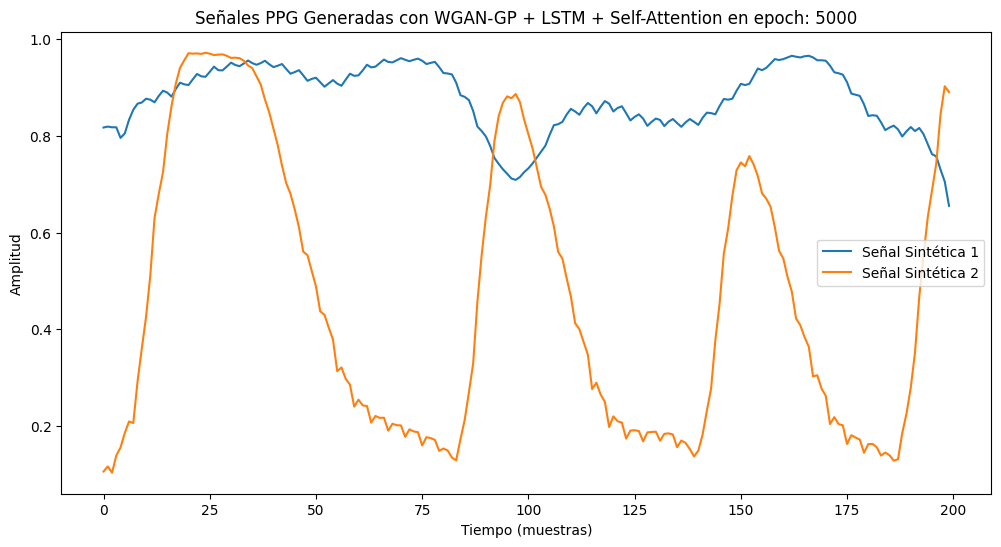

Epoch 5000: D Loss = 0.03323116898536682, G Loss = -5.7392730712890625
Epoch 5500: D Loss = 0.17150187492370605, G Loss = -4.7669219970703125


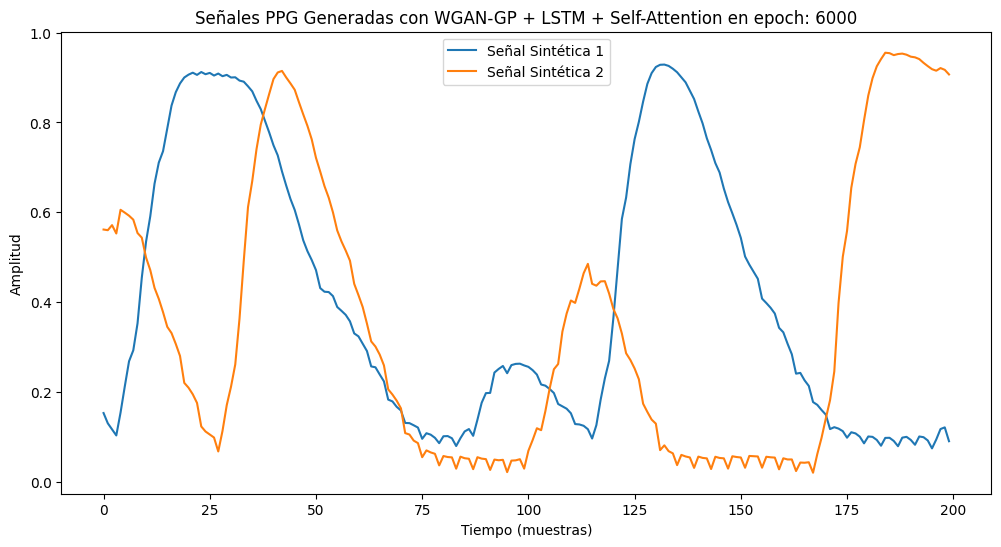

Epoch 6000: D Loss = 0.06344000995159149, G Loss = -3.702159881591797
Epoch 6500: D Loss = -0.018971893936395645, G Loss = -0.636232852935791


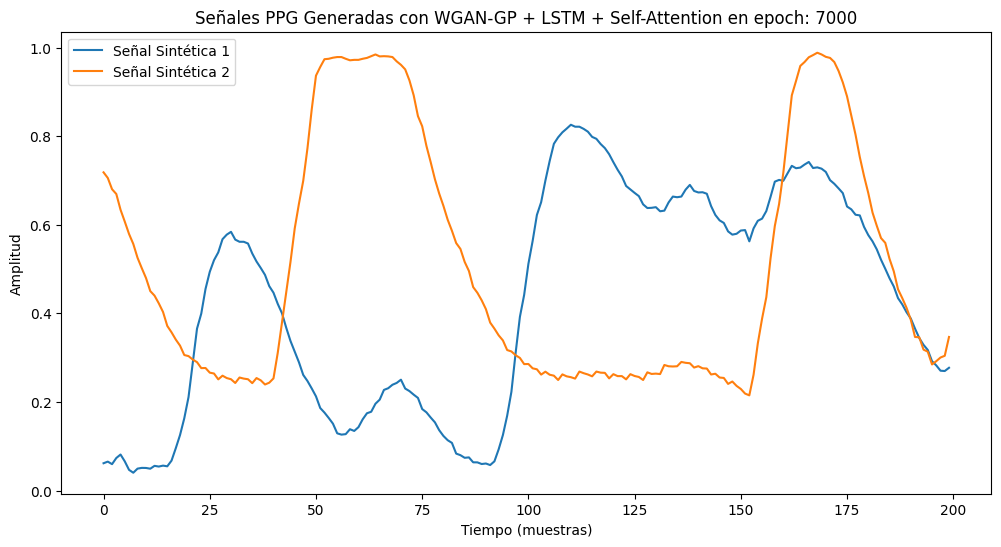

Epoch 7000: D Loss = -0.07806019484996796, G Loss = 0.9554952383041382
Epoch 7500: D Loss = 0.04313414916396141, G Loss = 0.9448227882385254


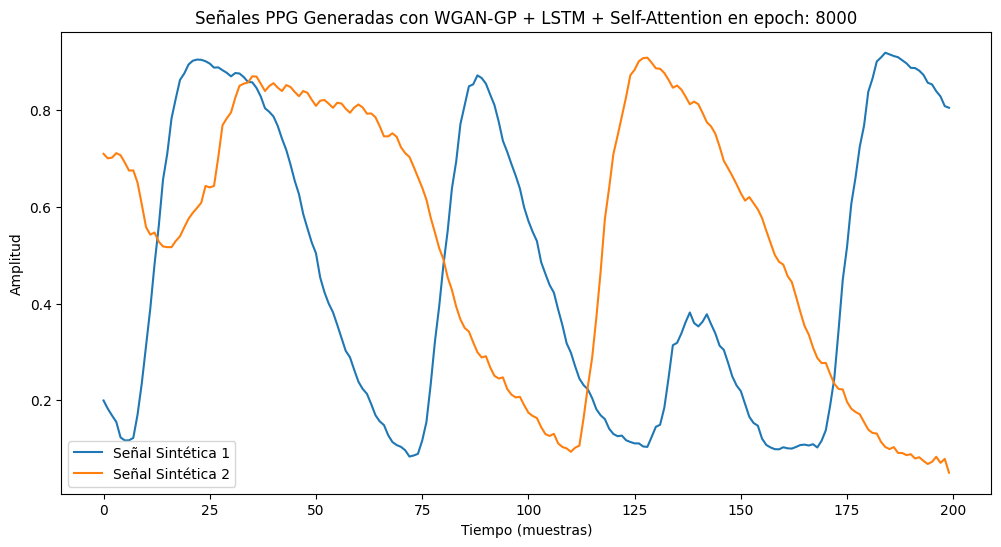

Epoch 8000: D Loss = -0.15831616520881653, G Loss = -2.5934317111968994
Epoch 8500: D Loss = -0.14317046105861664, G Loss = -4.831245422363281


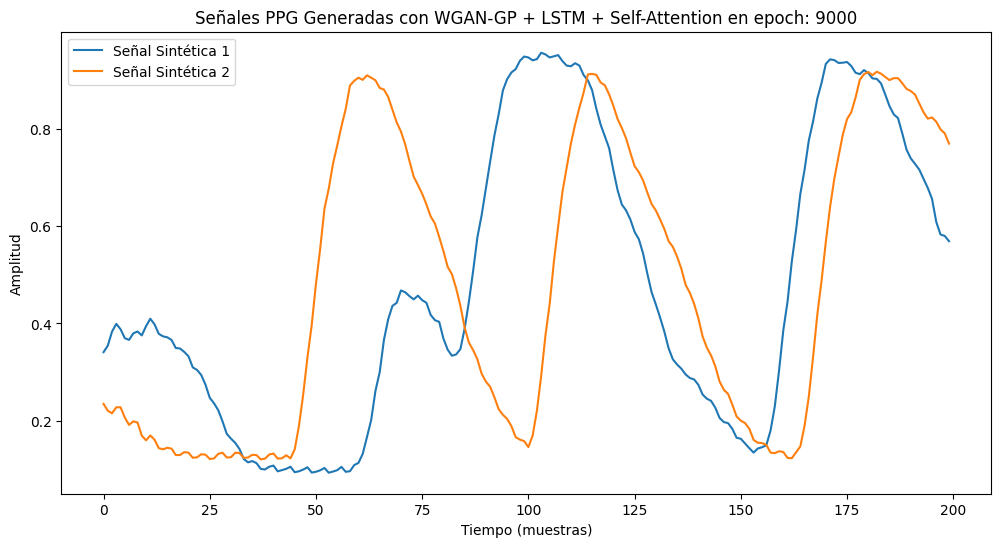

Epoch 9000: D Loss = -0.3201708495616913, G Loss = -5.4711456298828125
Epoch 9500: D Loss = -0.05627959966659546, G Loss = -11.213623046875


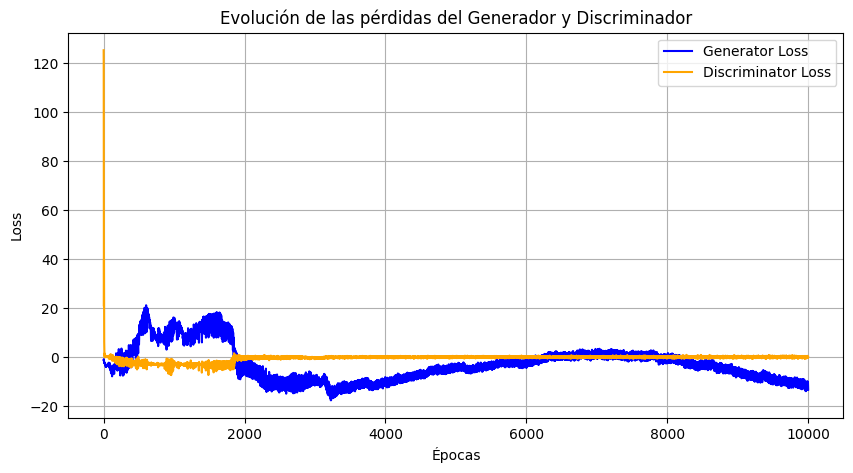

In [ ]:
train_wgan_gp(epochs=30000, batch_size=batch_size)
generator.save(f"/content/drive/MyDrive/Master Ingenieria de Telecomunicaciones/TFM/Producto_TFM/Modelos/modelo_wgan_gp/generator_{tipo}_epoch_{10000}.keras")
discriminator.save(f"/content/drive/MyDrive/Master Ingenieria de Telecomunicaciones/TFM/Producto_TFM/Modelos/modelo_wgan_gp/discriminator_{tipo}_epoch_{10000}.keras")

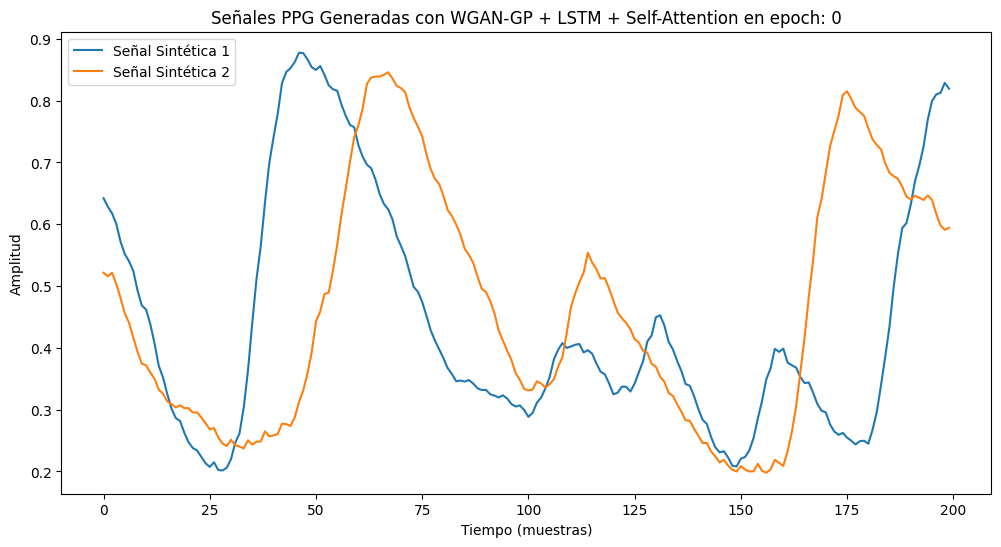

Epoch 0: D Loss = -0.501920759677887, G Loss = -13.438995361328125
Epoch 500: D Loss = 0.022912729531526566, G Loss = -14.4521484375


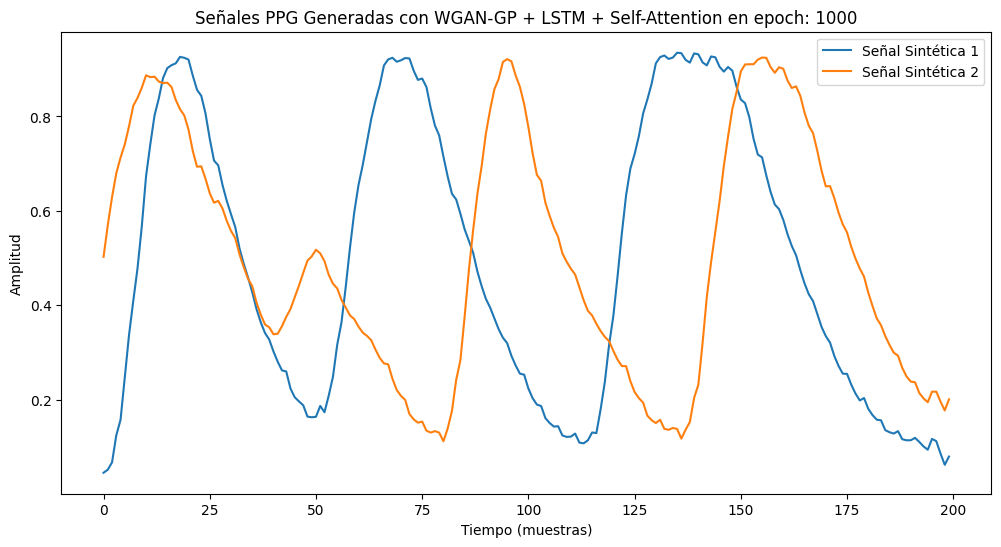

Epoch 1000: D Loss = -0.17518816888332367, G Loss = -15.80279541015625
Epoch 1500: D Loss = -0.2837284207344055, G Loss = -18.67822265625


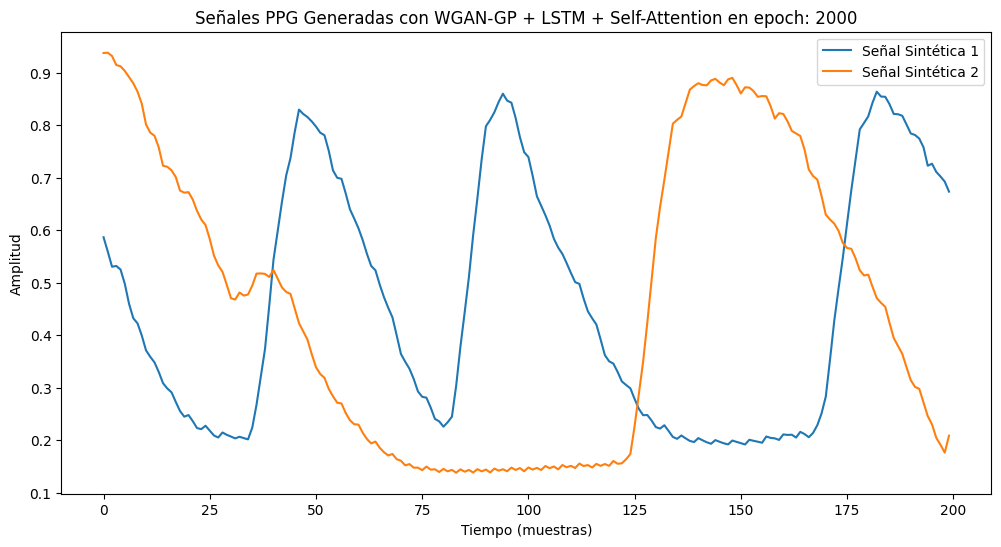

Epoch 2000: D Loss = 0.31780514121055603, G Loss = -23.3297119140625
Epoch 2500: D Loss = 0.10506681352853775, G Loss = -24.6234130859375


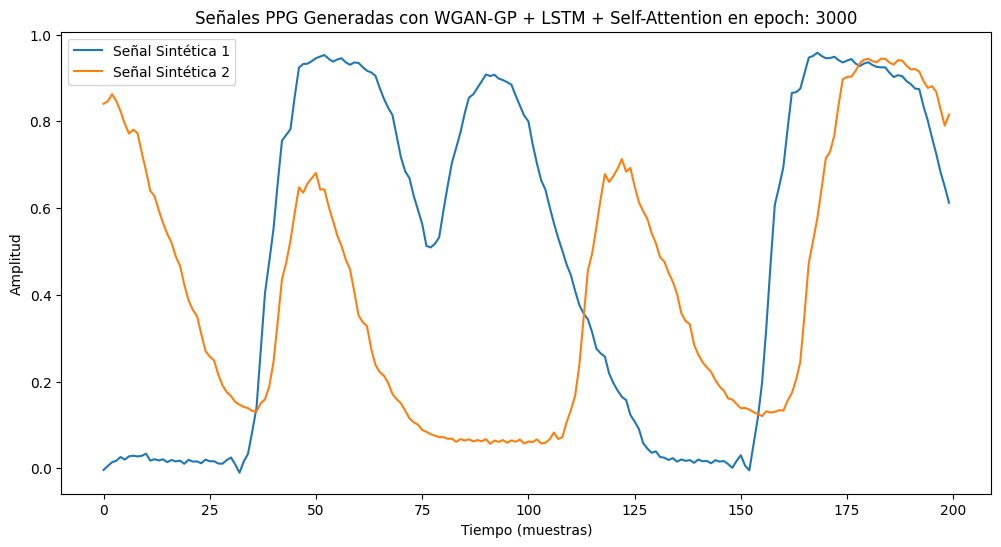

Epoch 3000: D Loss = 0.15280117094516754, G Loss = -27.29296875
Epoch 3500: D Loss = 0.27884989976882935, G Loss = -28.7818603515625


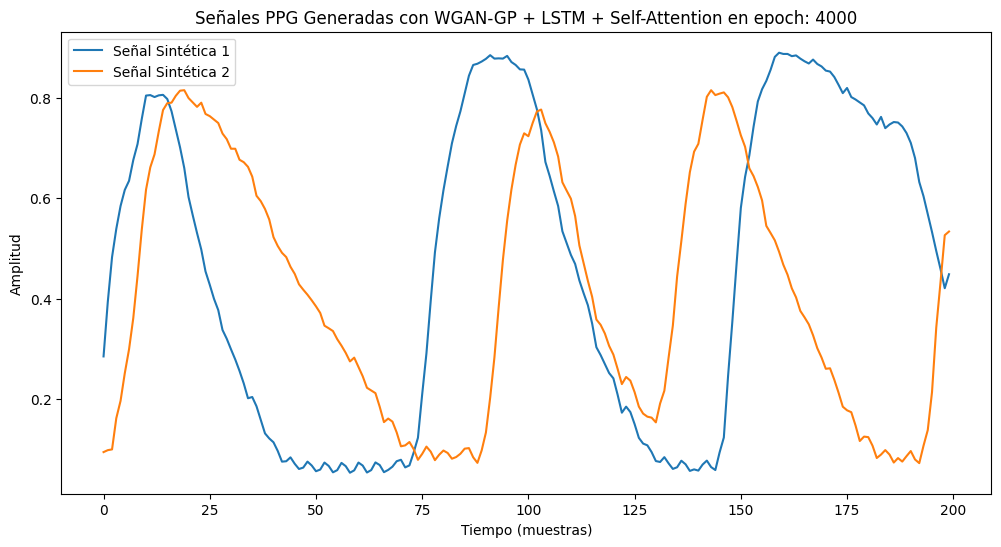

Epoch 4000: D Loss = 0.20470015704631805, G Loss = -29.79931640625
Epoch 4500: D Loss = 0.21151243150234222, G Loss = -31.9749755859375


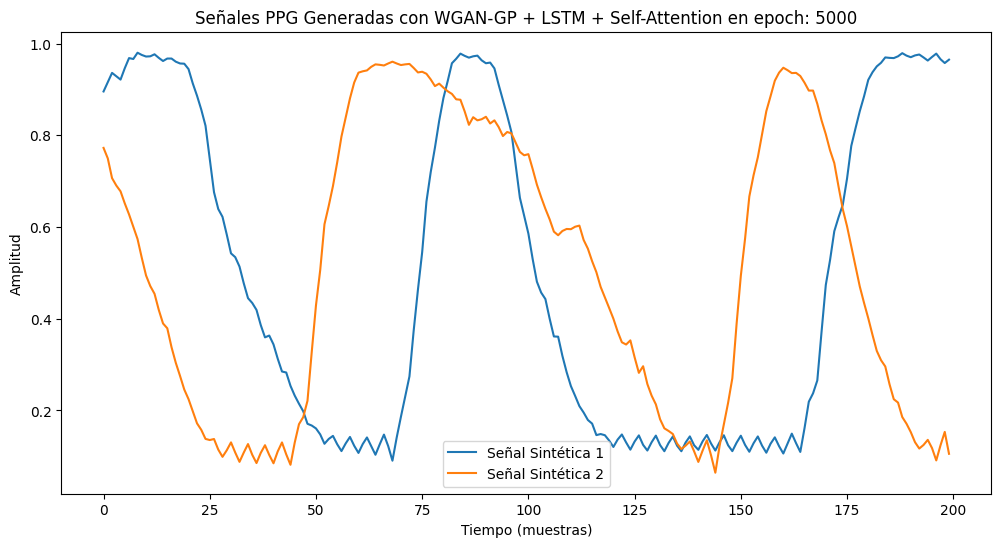

Epoch 5000: D Loss = 0.4801078736782074, G Loss = -35.7840576171875
Epoch 5500: D Loss = -0.25119417905807495, G Loss = -34.669921875


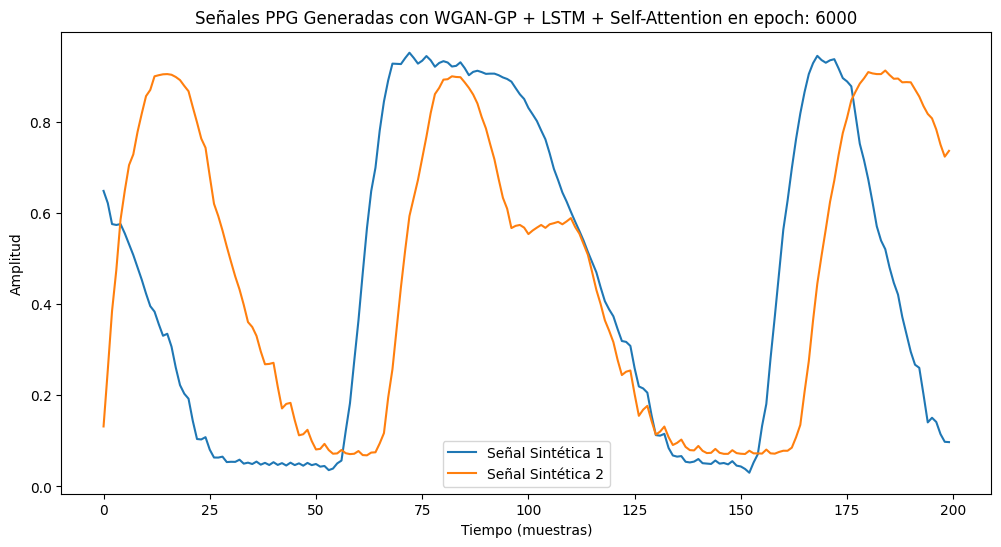

Epoch 6000: D Loss = -0.13947676122188568, G Loss = -33.7222900390625
Epoch 6500: D Loss = -0.270712286233902, G Loss = -29.89306640625


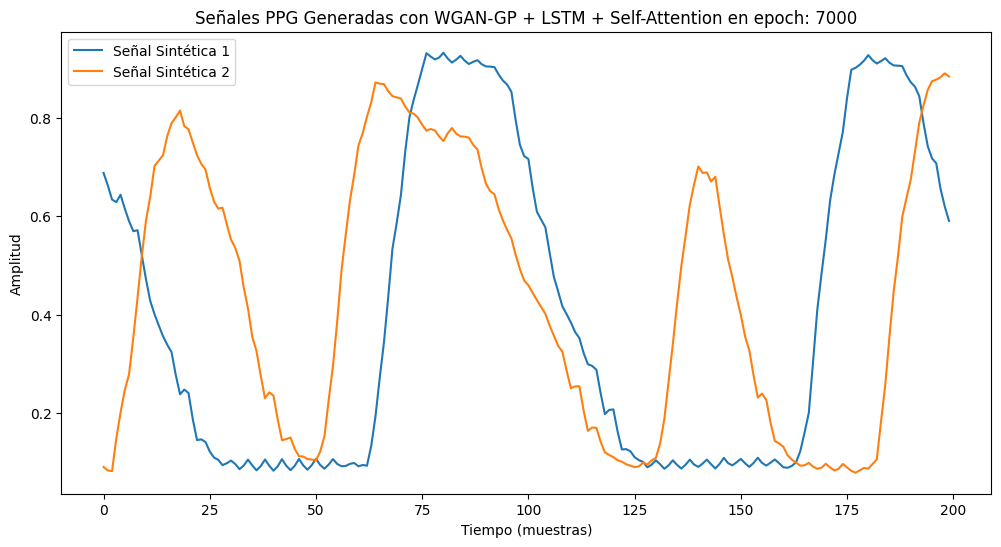

Epoch 7000: D Loss = 0.5343004465103149, G Loss = -29.2313232421875
Epoch 7500: D Loss = -0.04577150195837021, G Loss = -29.8521728515625


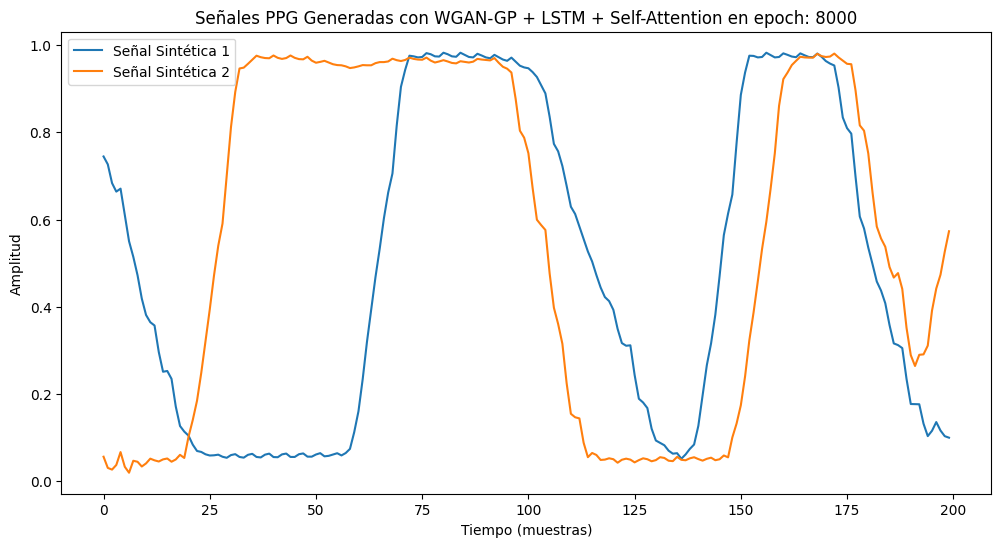

Epoch 8000: D Loss = -0.6020988821983337, G Loss = -30.12744140625
Epoch 8500: D Loss = 0.2838659882545471, G Loss = -24.9898681640625


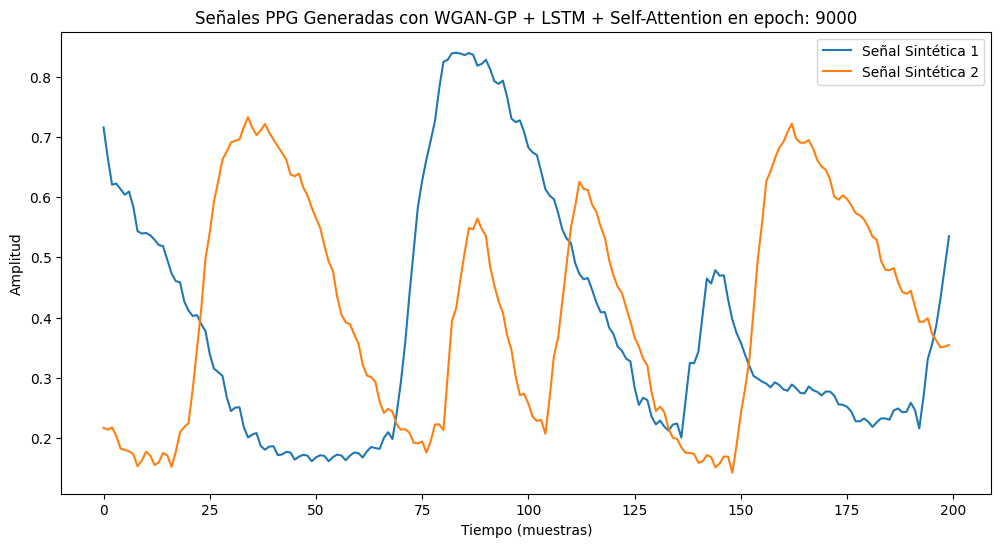

Epoch 9000: D Loss = -0.05353342741727829, G Loss = -26.5340576171875
Epoch 9500: D Loss = 0.5269610285758972, G Loss = -22.3016357421875


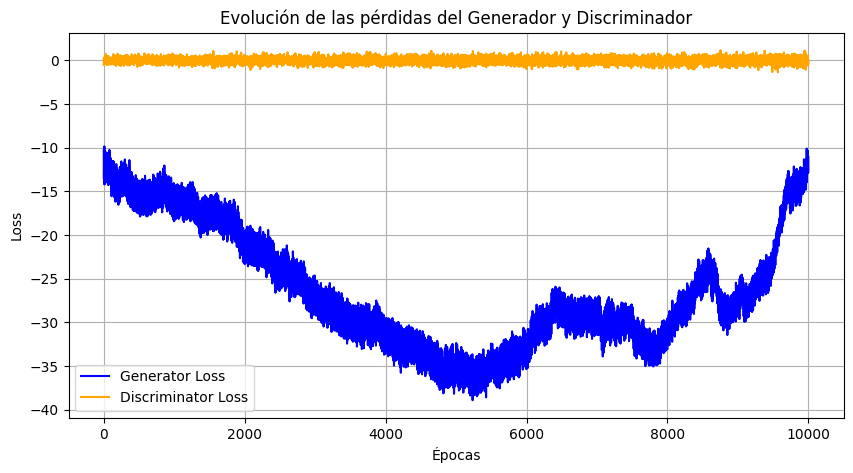

In [ ]:
generator = tf.keras.models.load_model("/content/drive/MyDrive/Master Ingenieria de Telecomunicaciones/TFM/Producto_TFM/Modelos/modelo_wgan_gp/generator_epoch_10000.keras")
discriminator = tf.keras.models.load_model("/content/drive/MyDrive/Master Ingenieria de Telecomunicaciones/TFM/Producto_TFM/Modelos/modelo_wgan_gp/discriminator_epoch_10000.keras")
gp_weight = 7  #MODIFICAR TAMBIEN EN TRAIN_STEP # 🔹 Ajustado para estabilidad
n_critic = 5  # 🔹 Número de actualizaciones de `D` antes de `G`
optimizer_g = tf.keras.optimizers.Adam(learning_rate=0.00007, beta_1=0.5, beta_2=0.9)
optimizer_d = tf.keras.optimizers.Adam(learning_rate=0.00002, beta_1=0.5, beta_2=0.9)

train_wgan_gp(epochs=10000, batch_size=batch_size)  # Añadir 10000 épocas más

generator.save(f"/content/drive/MyDrive/Master Ingenieria de Telecomunicaciones/TFM/Producto_TFM/Modelos/modelo_wgan_gp/generator_epoch_{20000}.keras")
discriminator.save(f"/content/drive/MyDrive/Master Ingenieria de Telecomunicaciones/TFM/Producto_TFM/Modelos/modelo_wgan_gp/discriminator_epoch_{20000}.keras")

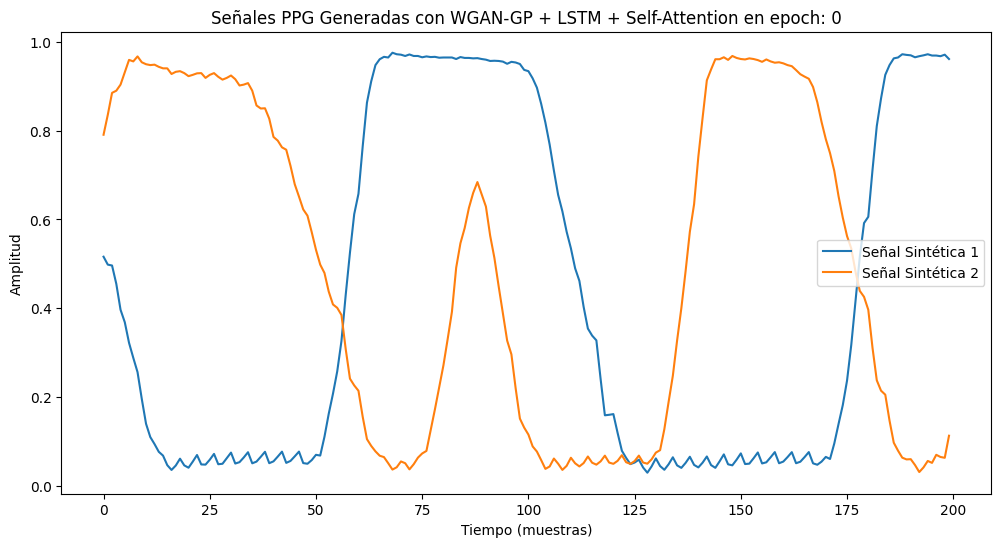

Epoch 0: D Loss = -0.0343487374484539, G Loss = -13.290771484375
Epoch 500: D Loss = -0.12571445107460022, G Loss = -10.210723876953125


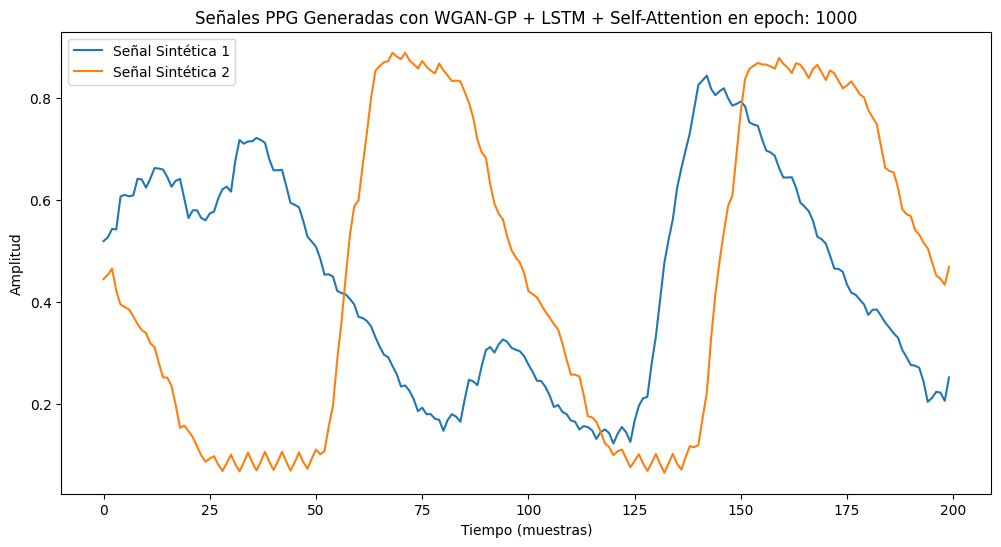

Epoch 1000: D Loss = -0.05248720198869705, G Loss = -9.038299560546875
Epoch 1500: D Loss = -0.11665520071983337, G Loss = -8.54364013671875


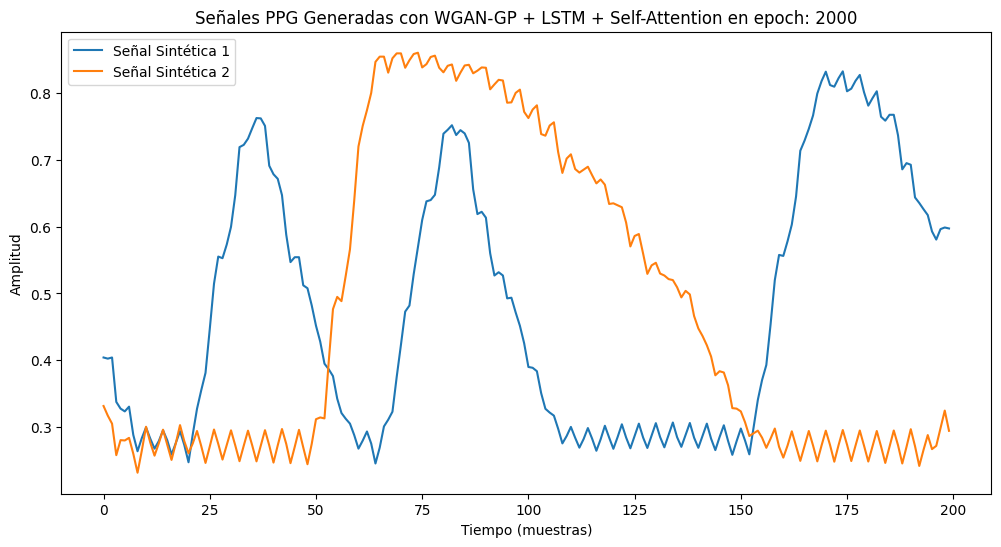

Epoch 2000: D Loss = -0.06957030296325684, G Loss = -3.799997329711914
Epoch 2500: D Loss = -0.07469730824232101, G Loss = -5.415530204772949


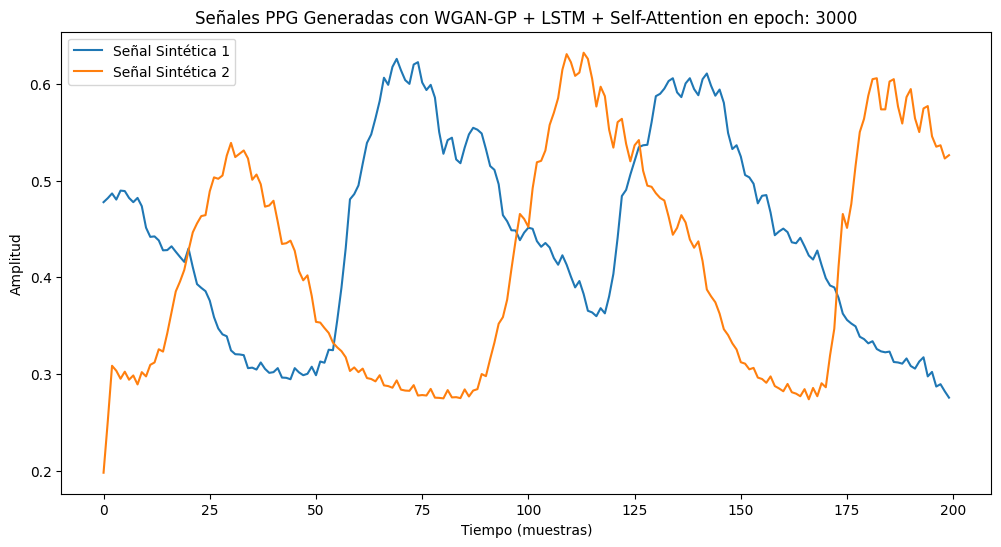

Epoch 3000: D Loss = 0.0895942747592926, G Loss = -5.65130615234375
Epoch 3500: D Loss = 0.19326063990592957, G Loss = -2.7233834266662598


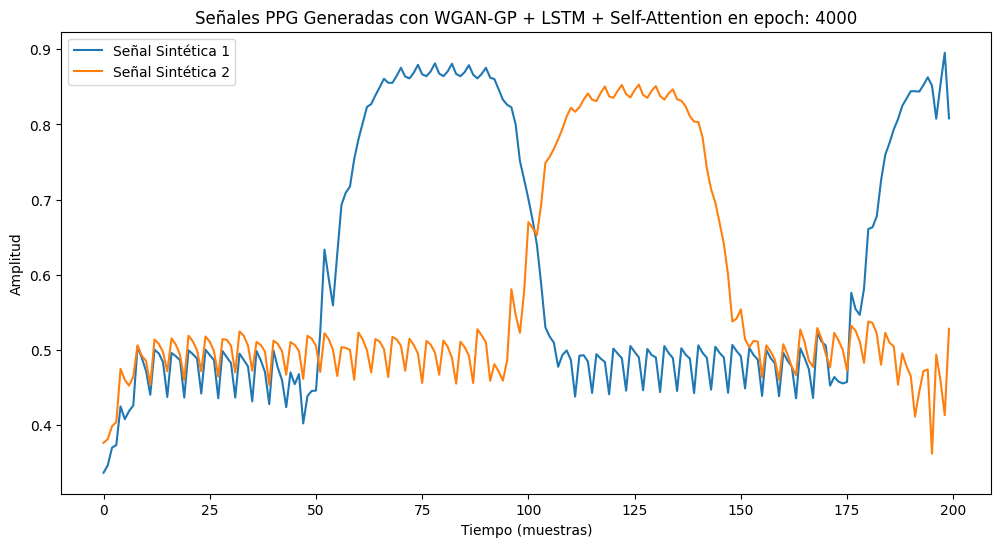

Epoch 4000: D Loss = 0.1435614377260208, G Loss = -7.8238372802734375
Epoch 4500: D Loss = -0.5252315998077393, G Loss = -7.65008544921875


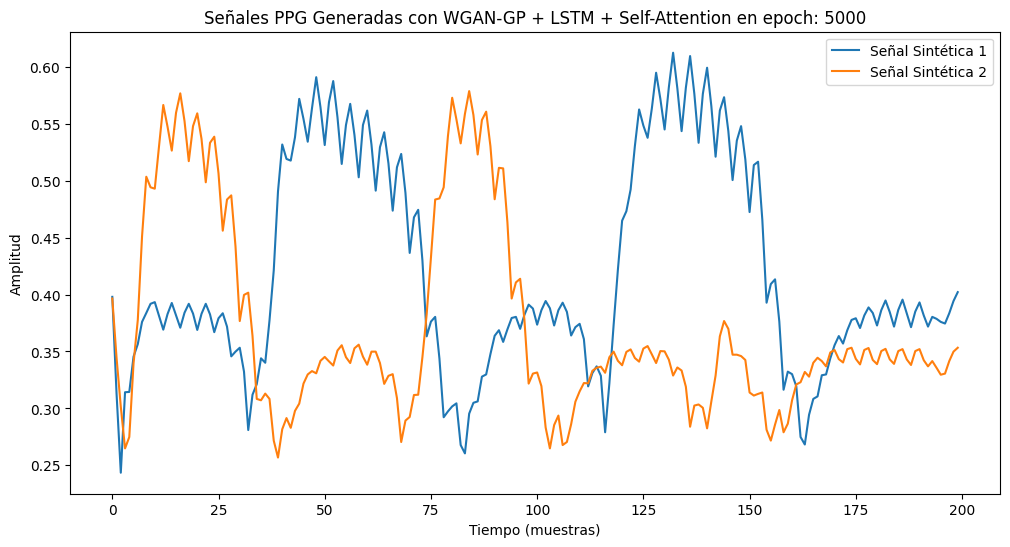

Epoch 5000: D Loss = 0.5971198678016663, G Loss = -4.867101669311523
Epoch 5500: D Loss = -0.09183000773191452, G Loss = -15.57281494140625


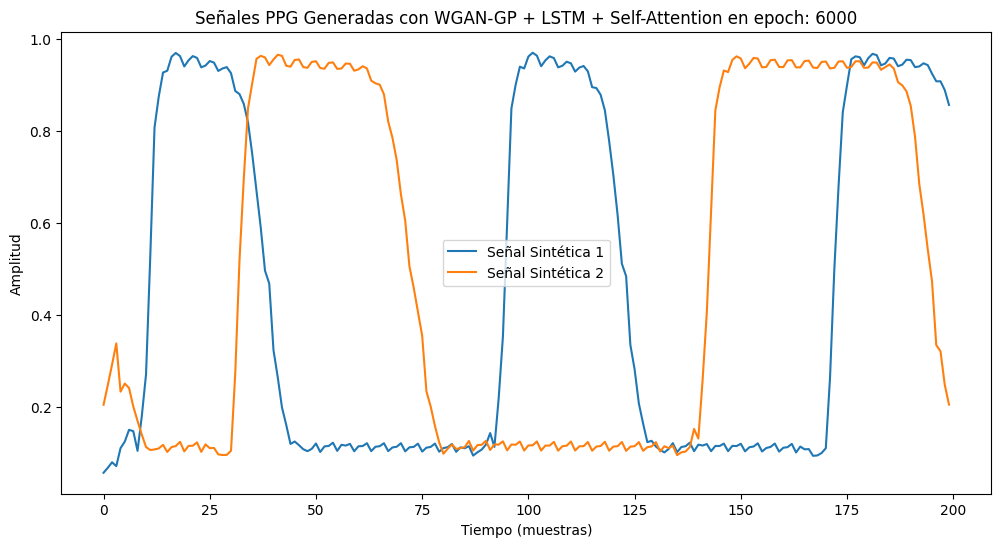

Epoch 6000: D Loss = 0.49561607837677, G Loss = -10.983718872070312
Epoch 6500: D Loss = 0.11997629702091217, G Loss = -17.55029296875


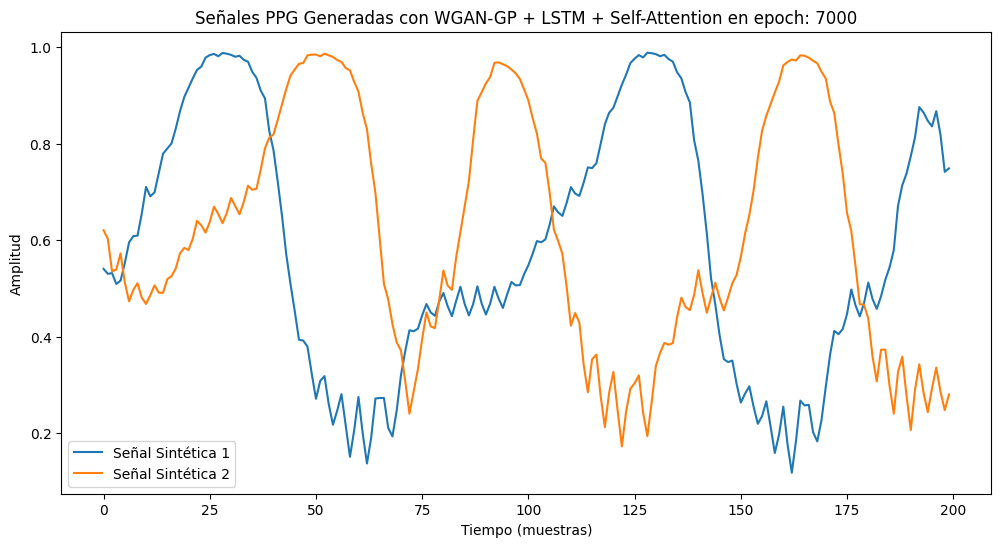

Epoch 7000: D Loss = -0.13924695551395416, G Loss = -18.891845703125
Epoch 7500: D Loss = -0.39076152443885803, G Loss = -19.29974365234375


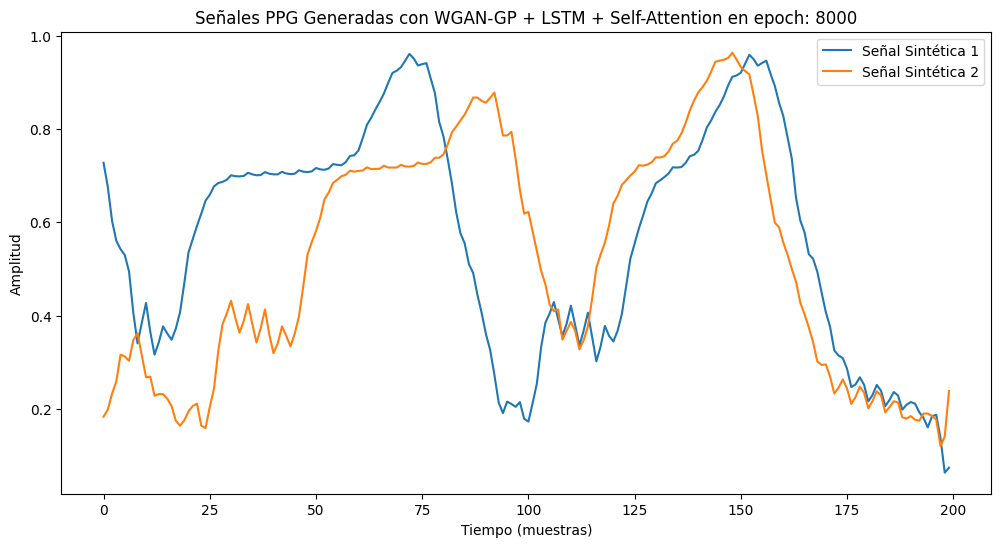

Epoch 8000: D Loss = 0.234053835272789, G Loss = -16.97186279296875
Epoch 8500: D Loss = -0.40584343671798706, G Loss = -21.6728515625


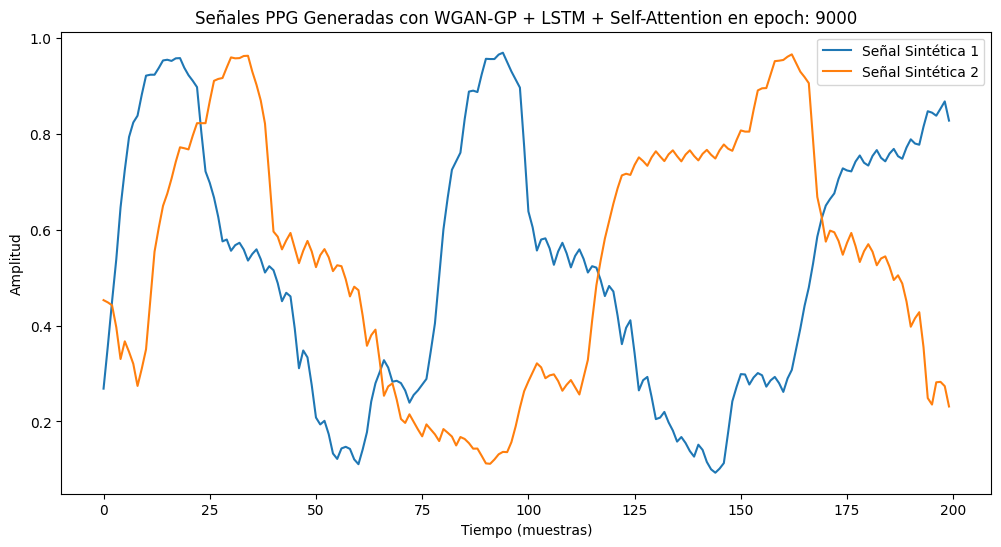

Epoch 9000: D Loss = 0.002554066479206085, G Loss = -21.81024169921875
Epoch 9500: D Loss = 0.4737868309020996, G Loss = -23.534912109375


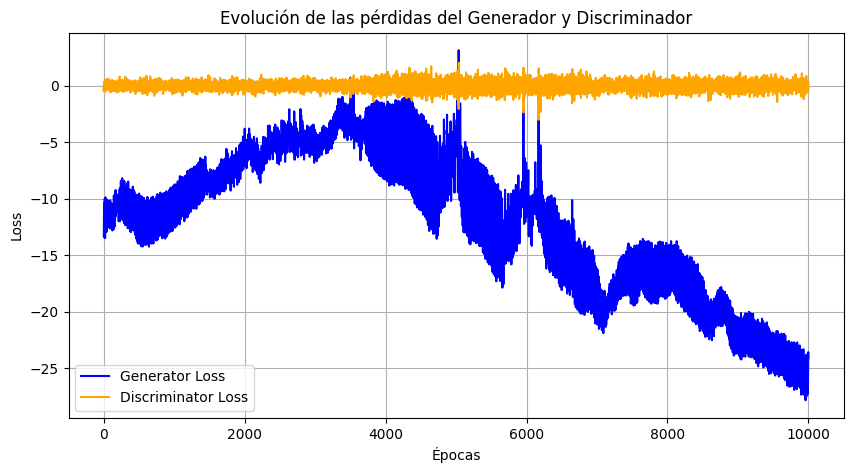

In [ ]:
generator = tf.keras.models.load_model("/content/drive/MyDrive/Master Ingenieria de Telecomunicaciones/TFM/Producto_TFM/Modelos/modelo_wgan_gp/generator_epoch_20000.keras")
discriminator = tf.keras.models.load_model("/content/drive/MyDrive/Master Ingenieria de Telecomunicaciones/TFM/Producto_TFM/Modelos/modelo_wgan_gp/discriminator_epoch_20000.keras")
gp_weight = 7  #MODIFICAR TAMBIEN EN TRAIN_STEP # 🔹 Ajustado para estabilidad
n_critic = 5  # 🔹 Número de actualizaciones de `D` antes de `G`
optimizer_g = tf.keras.optimizers.Adam(learning_rate=0.00006, beta_1=0.5, beta_2=0.9)
optimizer_d = tf.keras.optimizers.Adam(learning_rate=0.00003, beta_1=0.5, beta_2=0.9)

train_wgan_gp(epochs=10000, batch_size=batch_size)  # Añadir 10000 épocas más

generator.save(f"/content/drive/MyDrive/Master Ingenieria de Telecomunicaciones/TFM/Producto_TFM/Modelos/modelo_wgan_gp/generator_epoch_{30000}.keras")
discriminator.save(f"/content/drive/MyDrive/Master Ingenieria de Telecomunicaciones/TFM/Producto_TFM/Modelos/modelo_wgan_gp/discriminator_epoch_{30000}.keras")

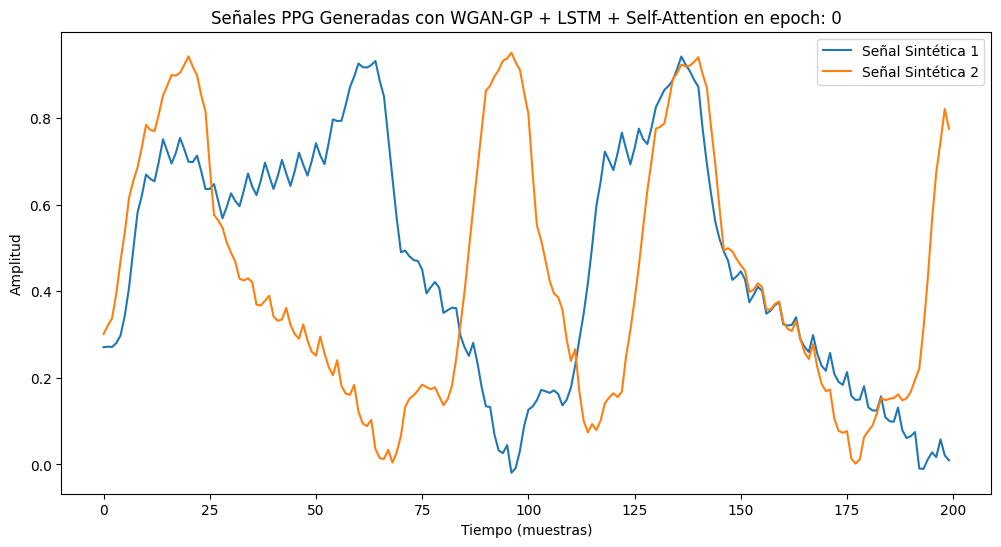

Epoch 0: D Loss = 0.05940090864896774, G Loss = -24.6640625
Epoch 500: D Loss = -0.057973336428403854, G Loss = -25.584716796875


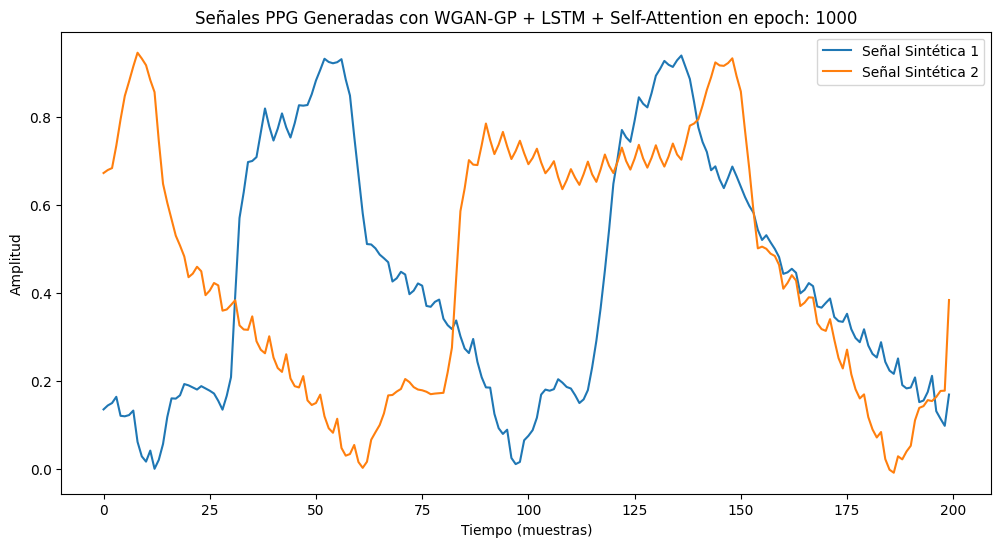

Epoch 1000: D Loss = 0.018044814467430115, G Loss = -31.6171875
Epoch 1500: D Loss = 0.12426070868968964, G Loss = -33.025146484375


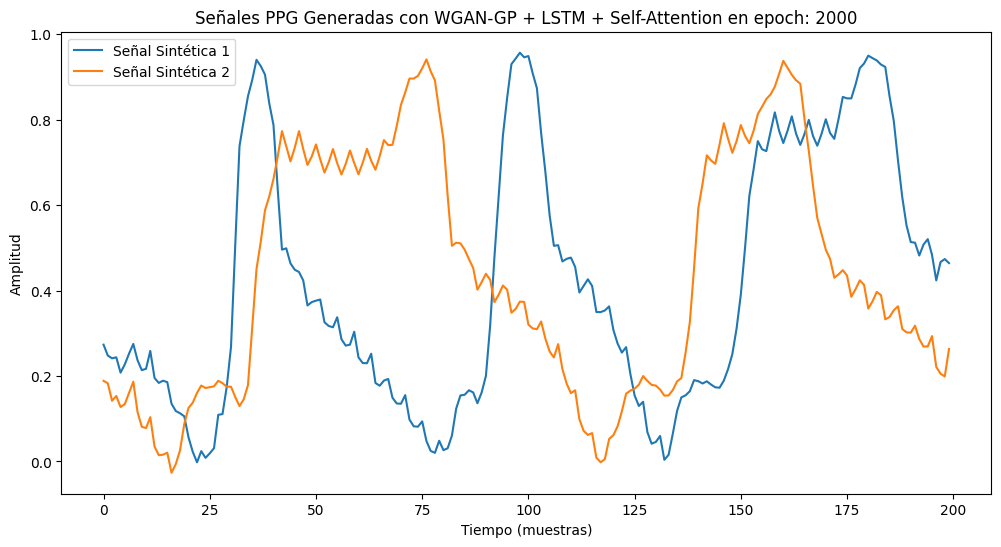

Epoch 2000: D Loss = -0.323192834854126, G Loss = -36.6632080078125
Epoch 2500: D Loss = -0.5525696873664856, G Loss = -38.29833984375


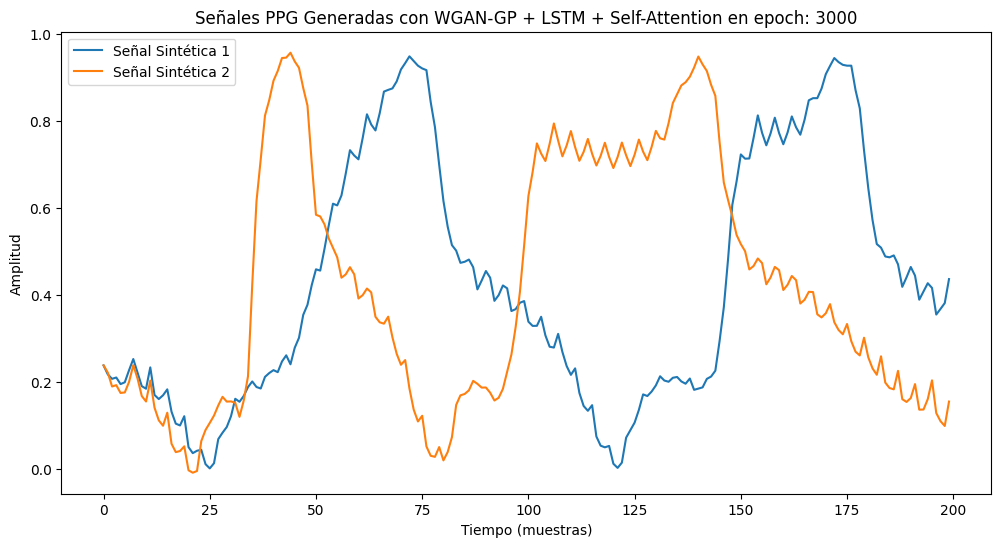

Epoch 3000: D Loss = 0.6717066764831543, G Loss = -38.500244140625
Epoch 3500: D Loss = -0.48342081904411316, G Loss = -42.904541015625


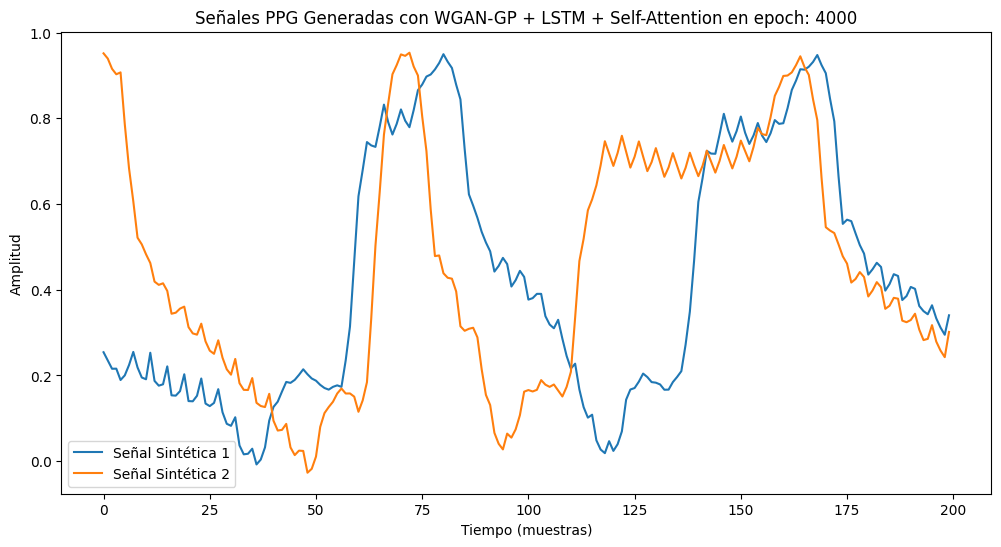

Epoch 4000: D Loss = -0.4836899936199188, G Loss = -43.694580078125
Epoch 4500: D Loss = -0.14934250712394714, G Loss = -46.424560546875


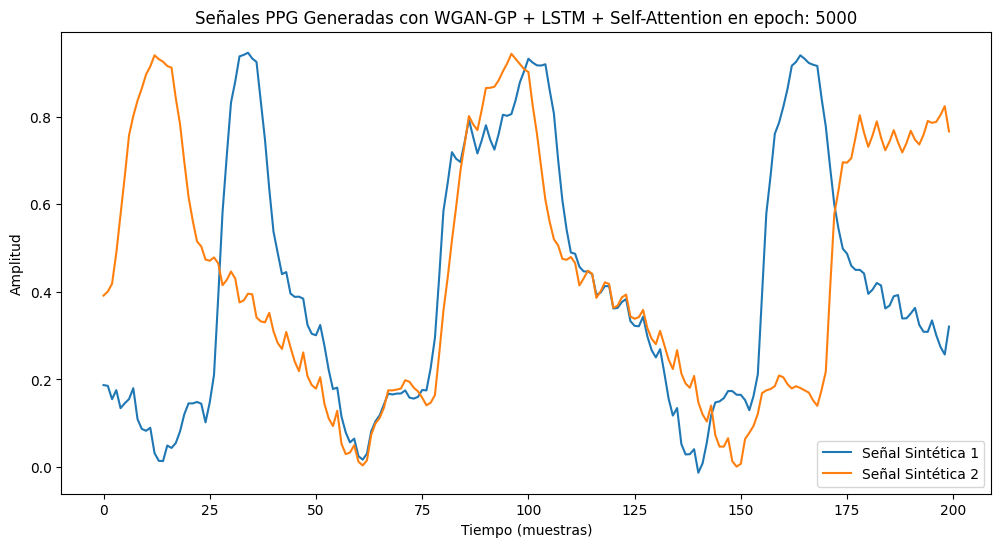

Epoch 5000: D Loss = -0.5957611203193665, G Loss = -48.766357421875
Epoch 5500: D Loss = -0.4018630087375641, G Loss = -52.87646484375


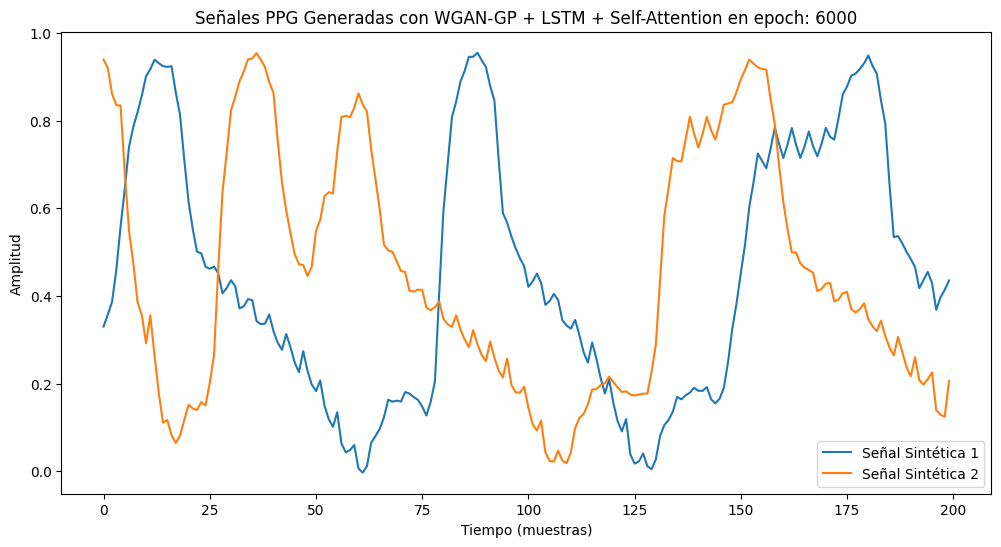

Epoch 6000: D Loss = -0.9305412769317627, G Loss = -52.232421875
Epoch 6500: D Loss = 0.08049134165048599, G Loss = -54.09814453125


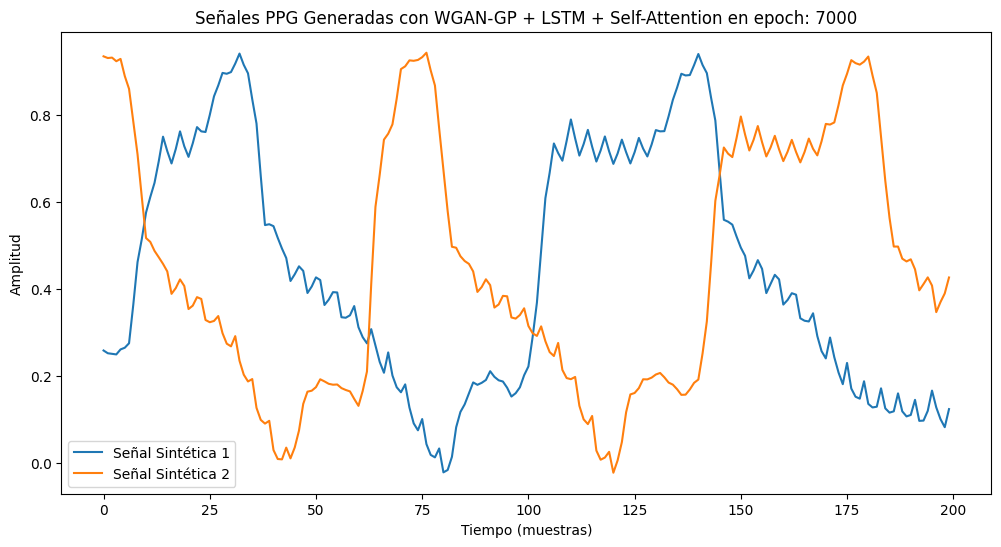

Epoch 7000: D Loss = 0.37564292550086975, G Loss = -57.473876953125
Epoch 7500: D Loss = 0.2832587957382202, G Loss = -60.11474609375


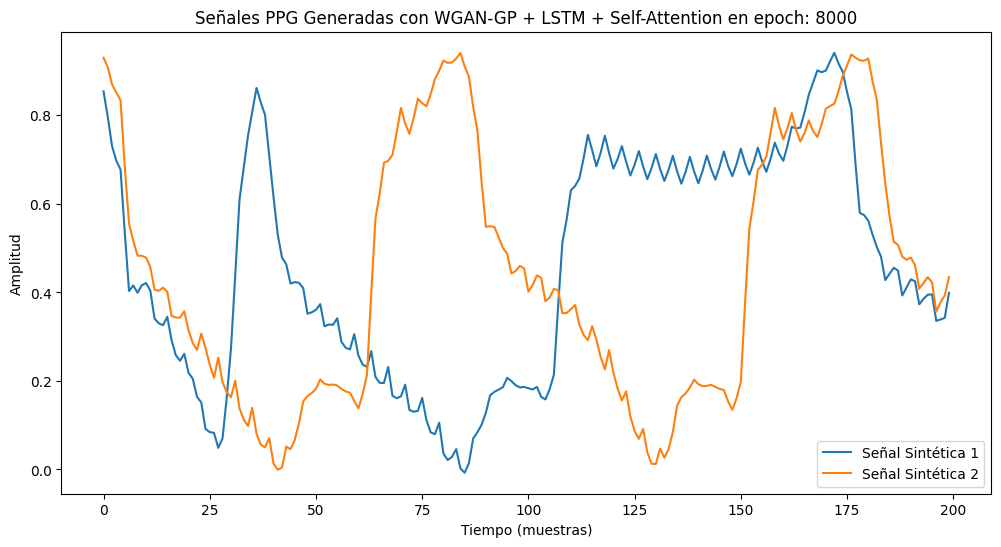

Epoch 8000: D Loss = 0.26383909583091736, G Loss = -64.4599609375
Epoch 8500: D Loss = -0.06071580573916435, G Loss = -65.93603515625


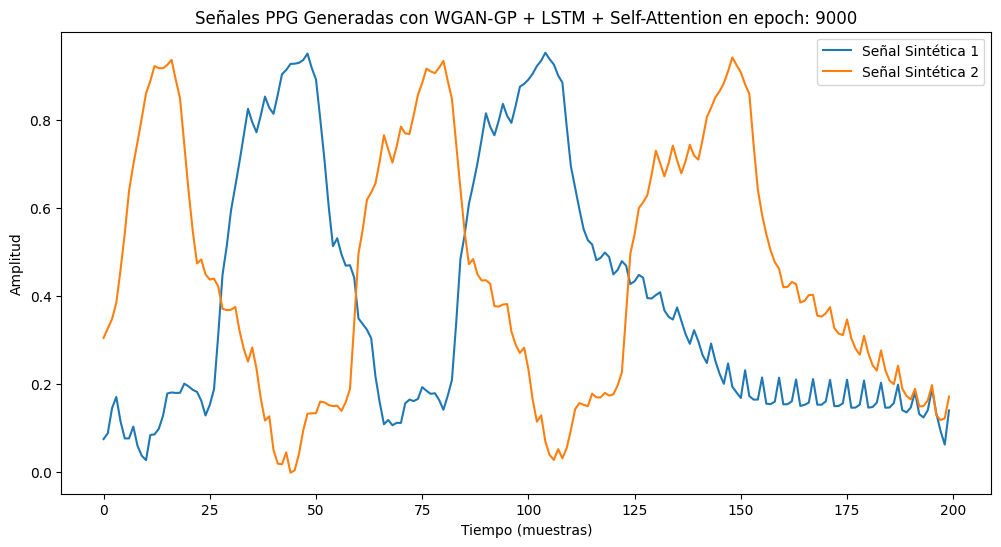

Epoch 9000: D Loss = 0.09325774013996124, G Loss = -68.40625
Epoch 9500: D Loss = 0.14953434467315674, G Loss = -67.591064453125


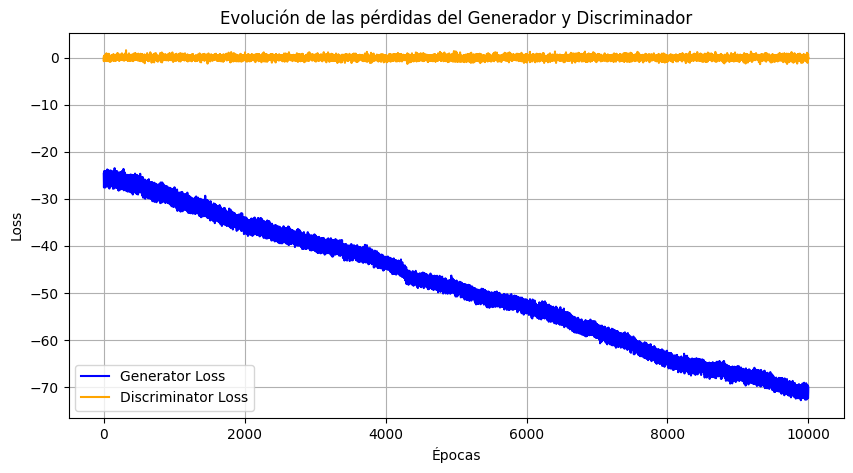

In [ ]:
generator = tf.keras.models.load_model("/content/drive/MyDrive/Master Ingenieria de Telecomunicaciones/TFM/Producto_TFM/Modelos/modelo_wgan_gp/generator_epoch_30000.keras")
discriminator = tf.keras.models.load_model("/content/drive/MyDrive/Master Ingenieria de Telecomunicaciones/TFM/Producto_TFM/Modelos/modelo_wgan_gp/discriminator_epoch_30000.keras")


train_wgan_gp(epochs=10000, batch_size=batch_size)  # Añadir 10000 épocas más

generator.save(f"/content/drive/MyDrive/Master Ingenieria de Telecomunicaciones/TFM/Producto_TFM/Modelos/modelo_wgan_gp/generator_epoch_{40000}.keras")
discriminator.save(f"/content/drive/MyDrive/Master Ingenieria de Telecomunicaciones/TFM/Producto_TFM/Modelos/modelo_wgan_gp/discriminator_epoch_{40000}.keras")


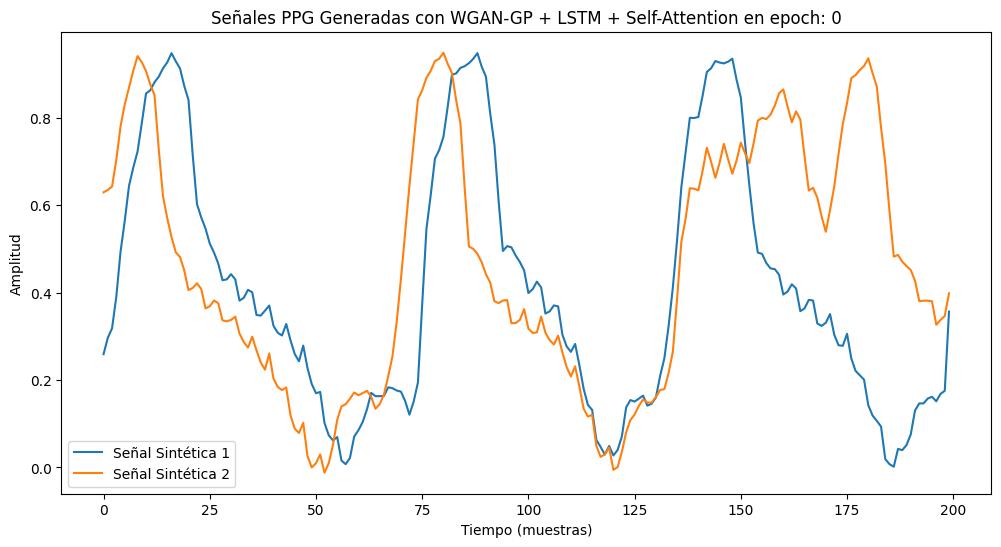

Epoch 0: D Loss = -0.8155992031097412, G Loss = -70.19873046875
Epoch 500: D Loss = -0.15283237397670746, G Loss = -74.1181640625


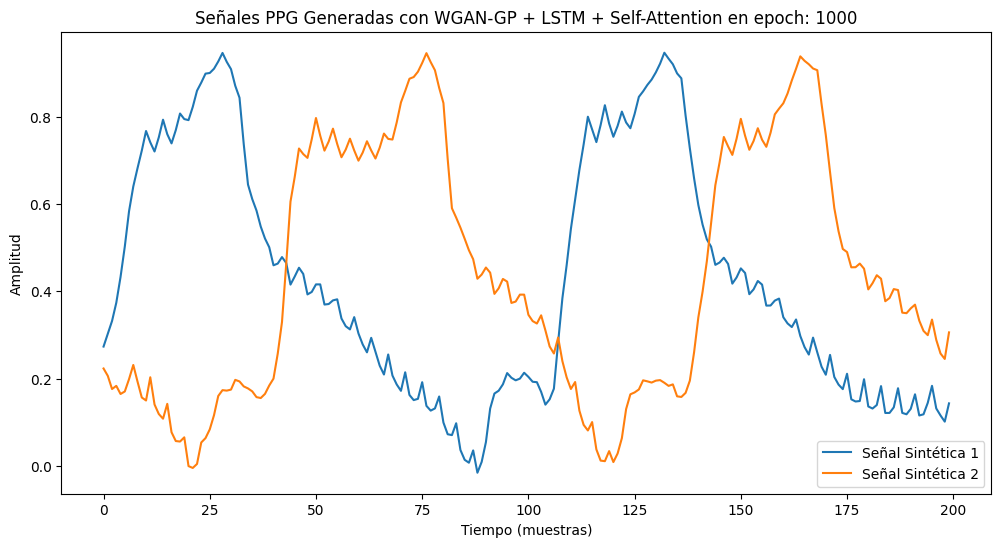

Epoch 1000: D Loss = 0.36513882875442505, G Loss = -75.95654296875
Epoch 1500: D Loss = -0.7550255060195923, G Loss = -75.59521484375


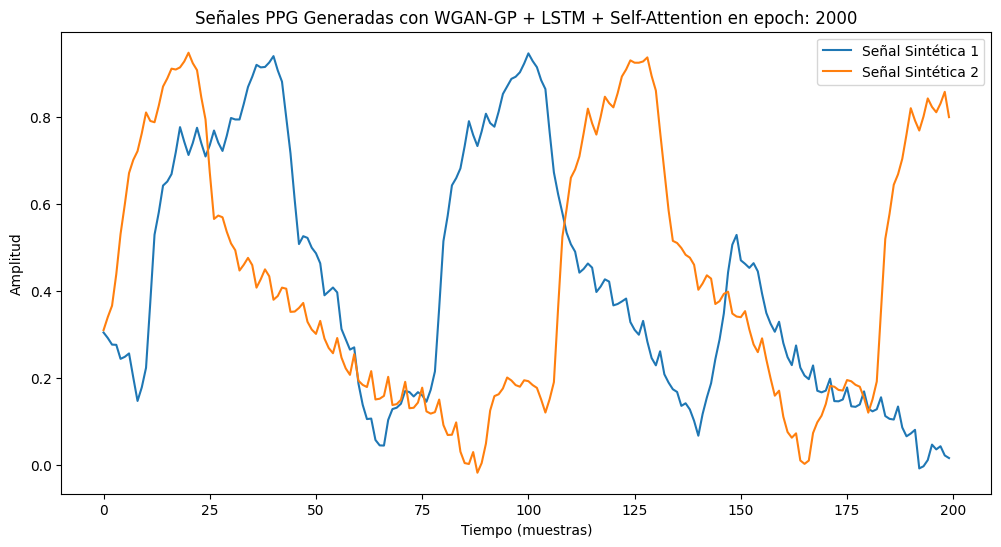

Epoch 2000: D Loss = 0.34934088587760925, G Loss = -77.763671875
Epoch 2500: D Loss = -0.3365321755409241, G Loss = -84.013671875


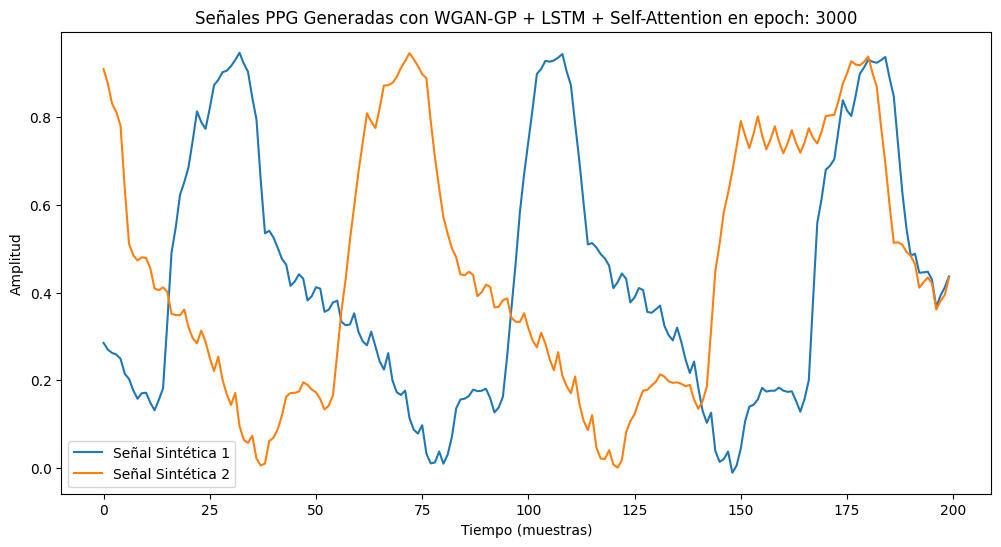

Epoch 3000: D Loss = 0.12681198120117188, G Loss = -84.1884765625
Epoch 3500: D Loss = 0.32487204670906067, G Loss = -84.83203125


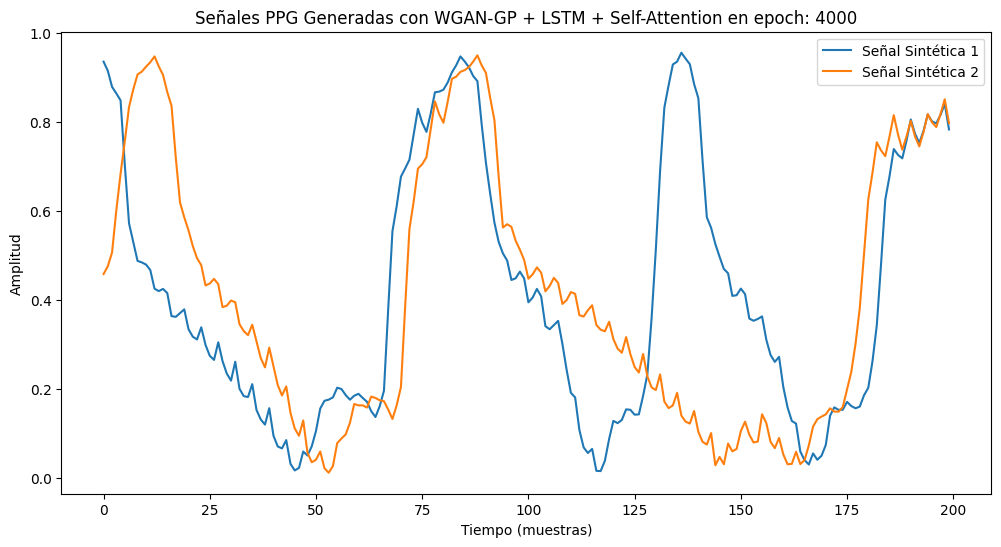

Epoch 4000: D Loss = 0.09363970160484314, G Loss = -91.75439453125
Epoch 4500: D Loss = -0.09168864041566849, G Loss = -92.5380859375


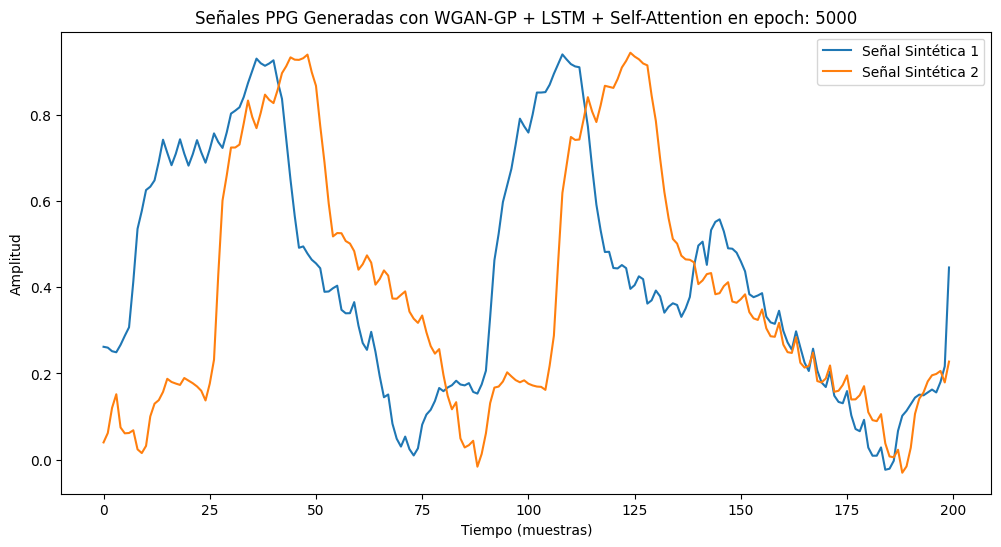

Epoch 5000: D Loss = -0.7932689785957336, G Loss = -93.73681640625
Epoch 5500: D Loss = 0.0022428473457694054, G Loss = -94.46630859375


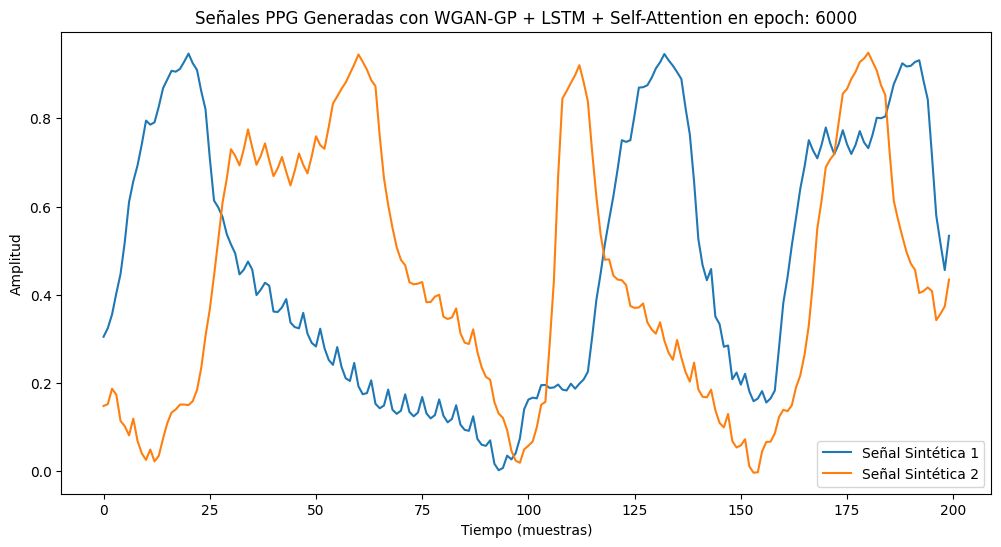

Epoch 6000: D Loss = 0.3490298390388489, G Loss = -96.85546875
Epoch 6500: D Loss = 0.6172020435333252, G Loss = -99.0244140625


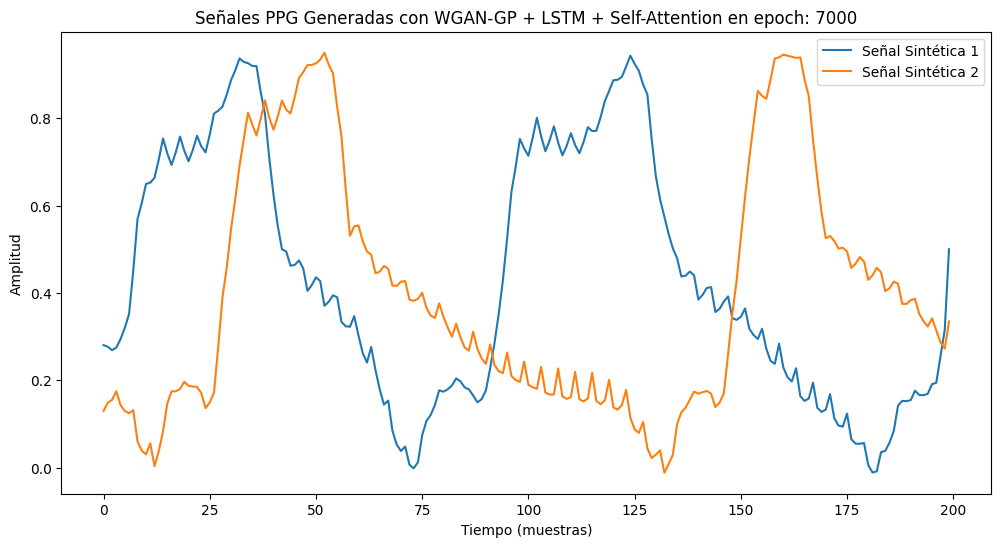

Epoch 7000: D Loss = -0.1783531904220581, G Loss = -99.49072265625
Epoch 7500: D Loss = 0.6048683524131775, G Loss = -100.19921875


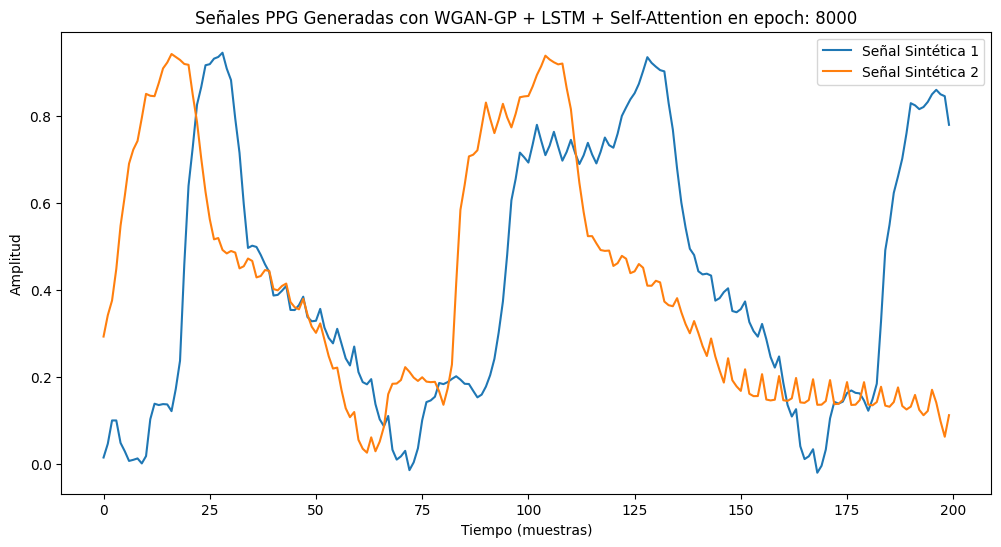

Epoch 8000: D Loss = -0.2876168489456177, G Loss = -100.31591796875
Epoch 8500: D Loss = -0.48688676953315735, G Loss = -102.1376953125


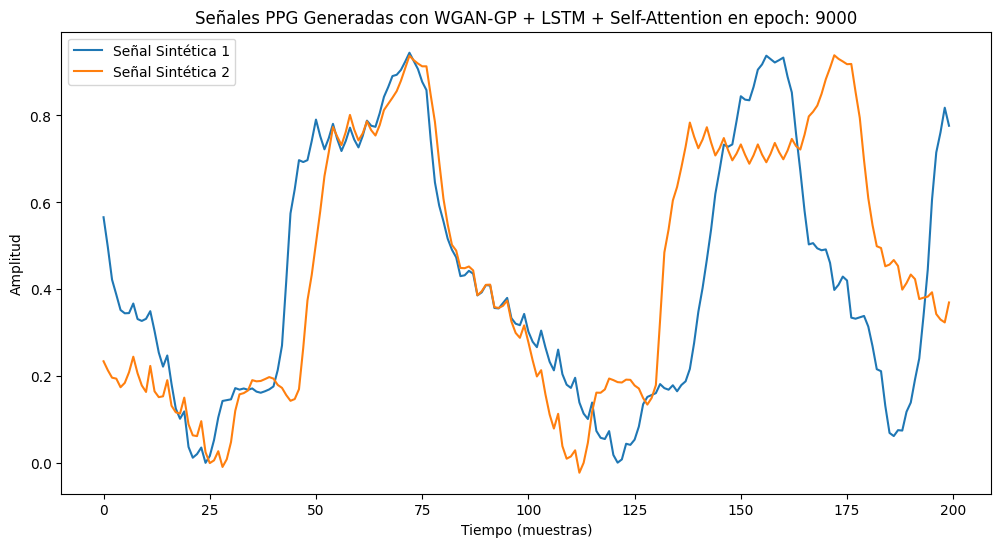

Epoch 9000: D Loss = -0.07932446151971817, G Loss = -103.21435546875
Epoch 9500: D Loss = -0.4532453417778015, G Loss = -106.43701171875


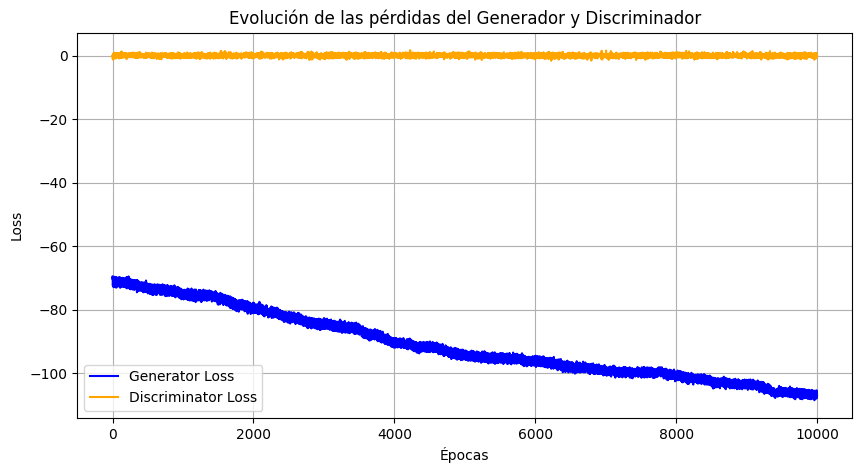

In [ ]:
generator = tf.keras.models.load_model("/content/drive/MyDrive/Master Ingenieria de Telecomunicaciones/TFM/Producto_TFM/Modelos/modelo_wgan_gp/generator_epoch_40000.keras")
discriminator = tf.keras.models.load_model("/content/drive/MyDrive/Master Ingenieria de Telecomunicaciones/TFM/Producto_TFM/Modelos/modelo_wgan_gp/discriminator_epoch_40000.keras")
#gp_weight = 7  #MODIFICAR TAMBIEN EN TRAIN_STEP # 🔹 Ajustado para estabilidad
#n_critic = 5  # 🔹 Número de actualizaciones de `D` antes de `G`
optimizer_g = tf.keras.optimizers.Adam(learning_rate=0.00005, beta_1=0.5, beta_2=0.9)
optimizer_d = tf.keras.optimizers.Adam(learning_rate=0.00005, beta_1=0.5, beta_2=0.9)

train_wgan_gp(epochs=10000, batch_size=batch_size)  # Añadir 10000 épocas más

generator.save(f"/content/drive/MyDrive/Master Ingenieria de Telecomunicaciones/TFM/Producto_TFM/Modelos/modelo_wgan_gp/generator_epoch_{50000}.keras")
discriminator.save(f"/content/drive/MyDrive/Master Ingenieria de Telecomunicaciones/TFM/Producto_TFM/Modelos/modelo_wgan_gp/discriminator_epoch_{50000}.keras")

## Visualizacion de ejemplos

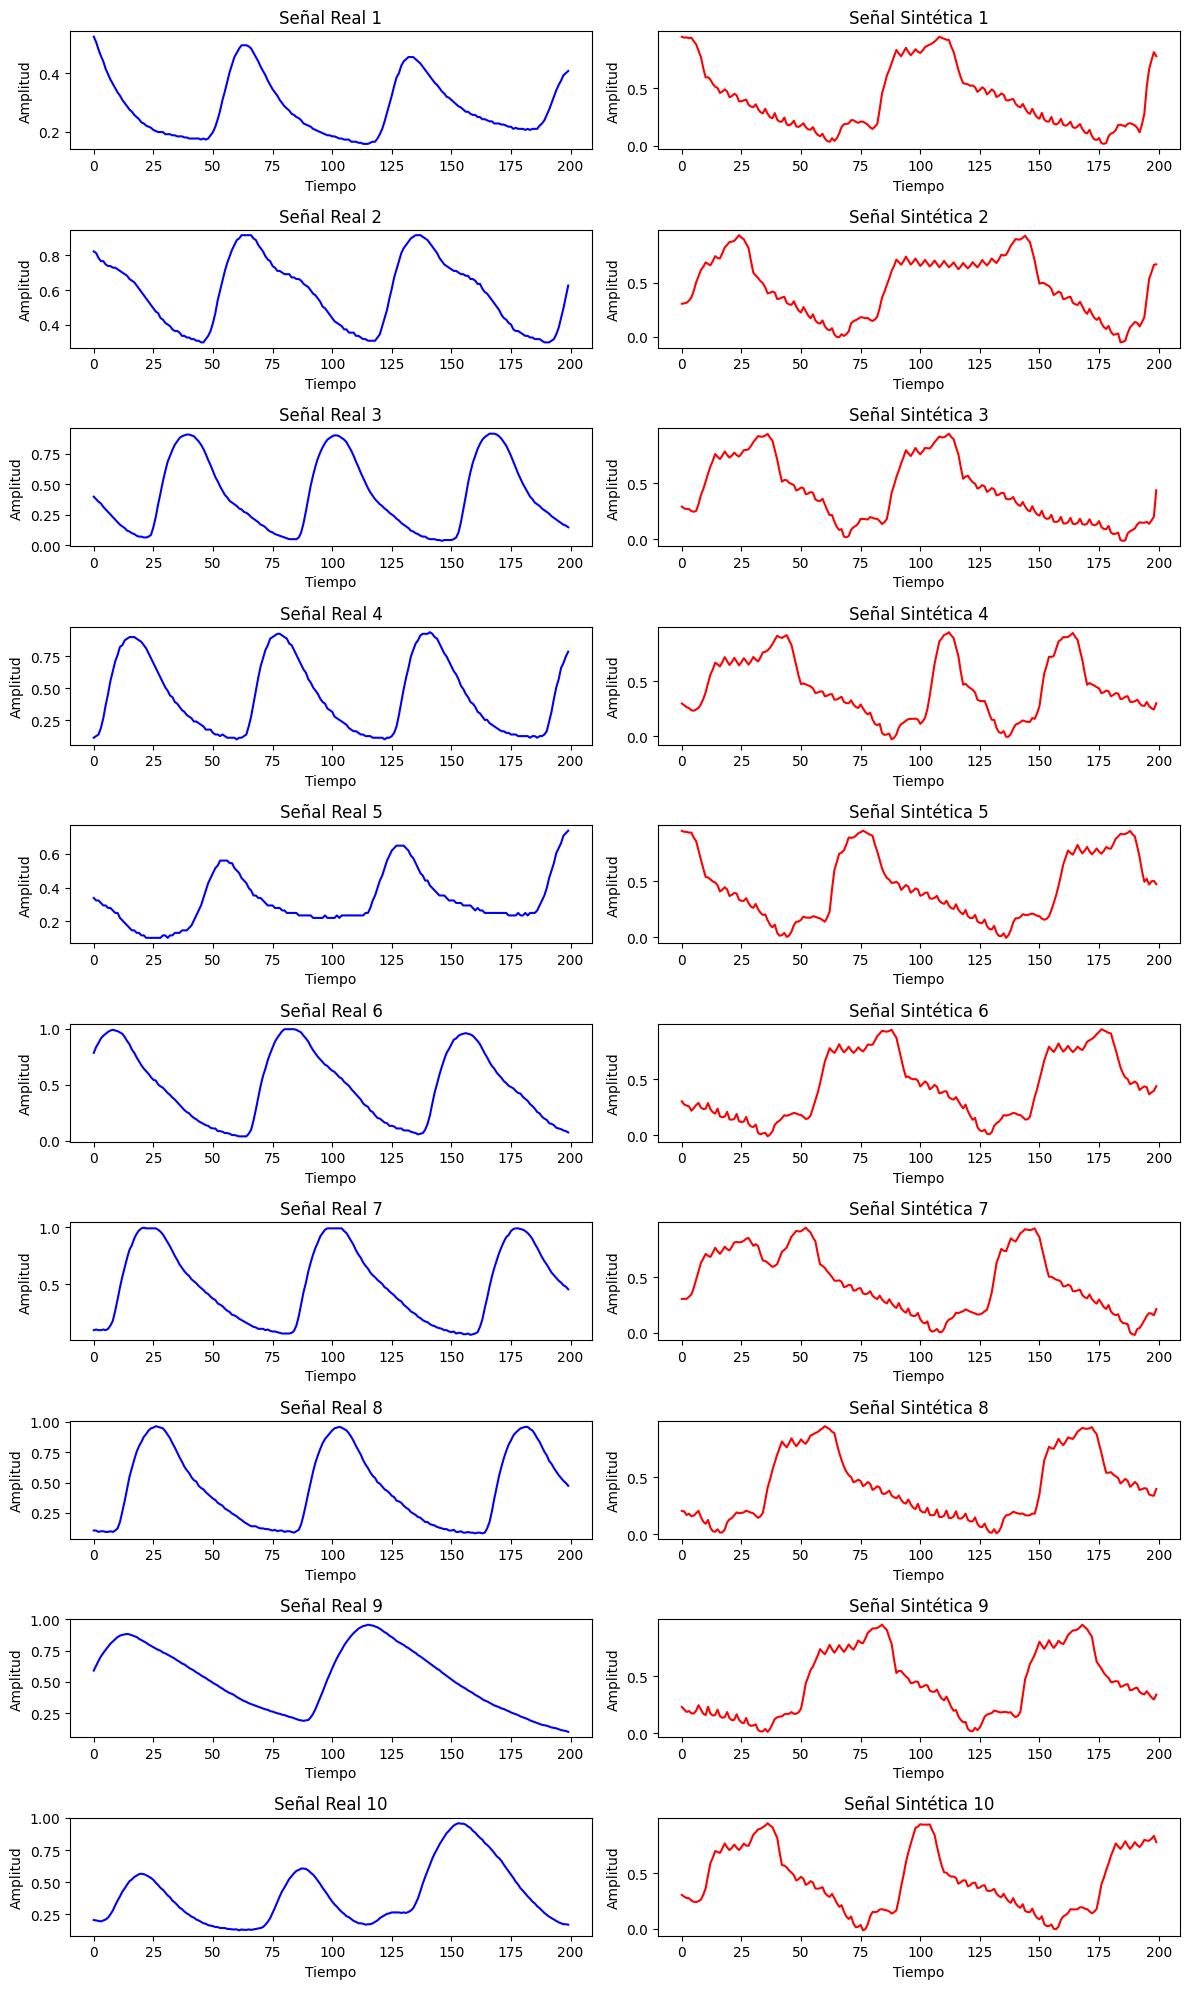

In [ ]:
synthetic_ppg_signals = generate_synthetic_ppg_wgan(100)
plot_real_vs_synthetic(ppg_signals, synthetic_ppg_signals, num_samples=10)


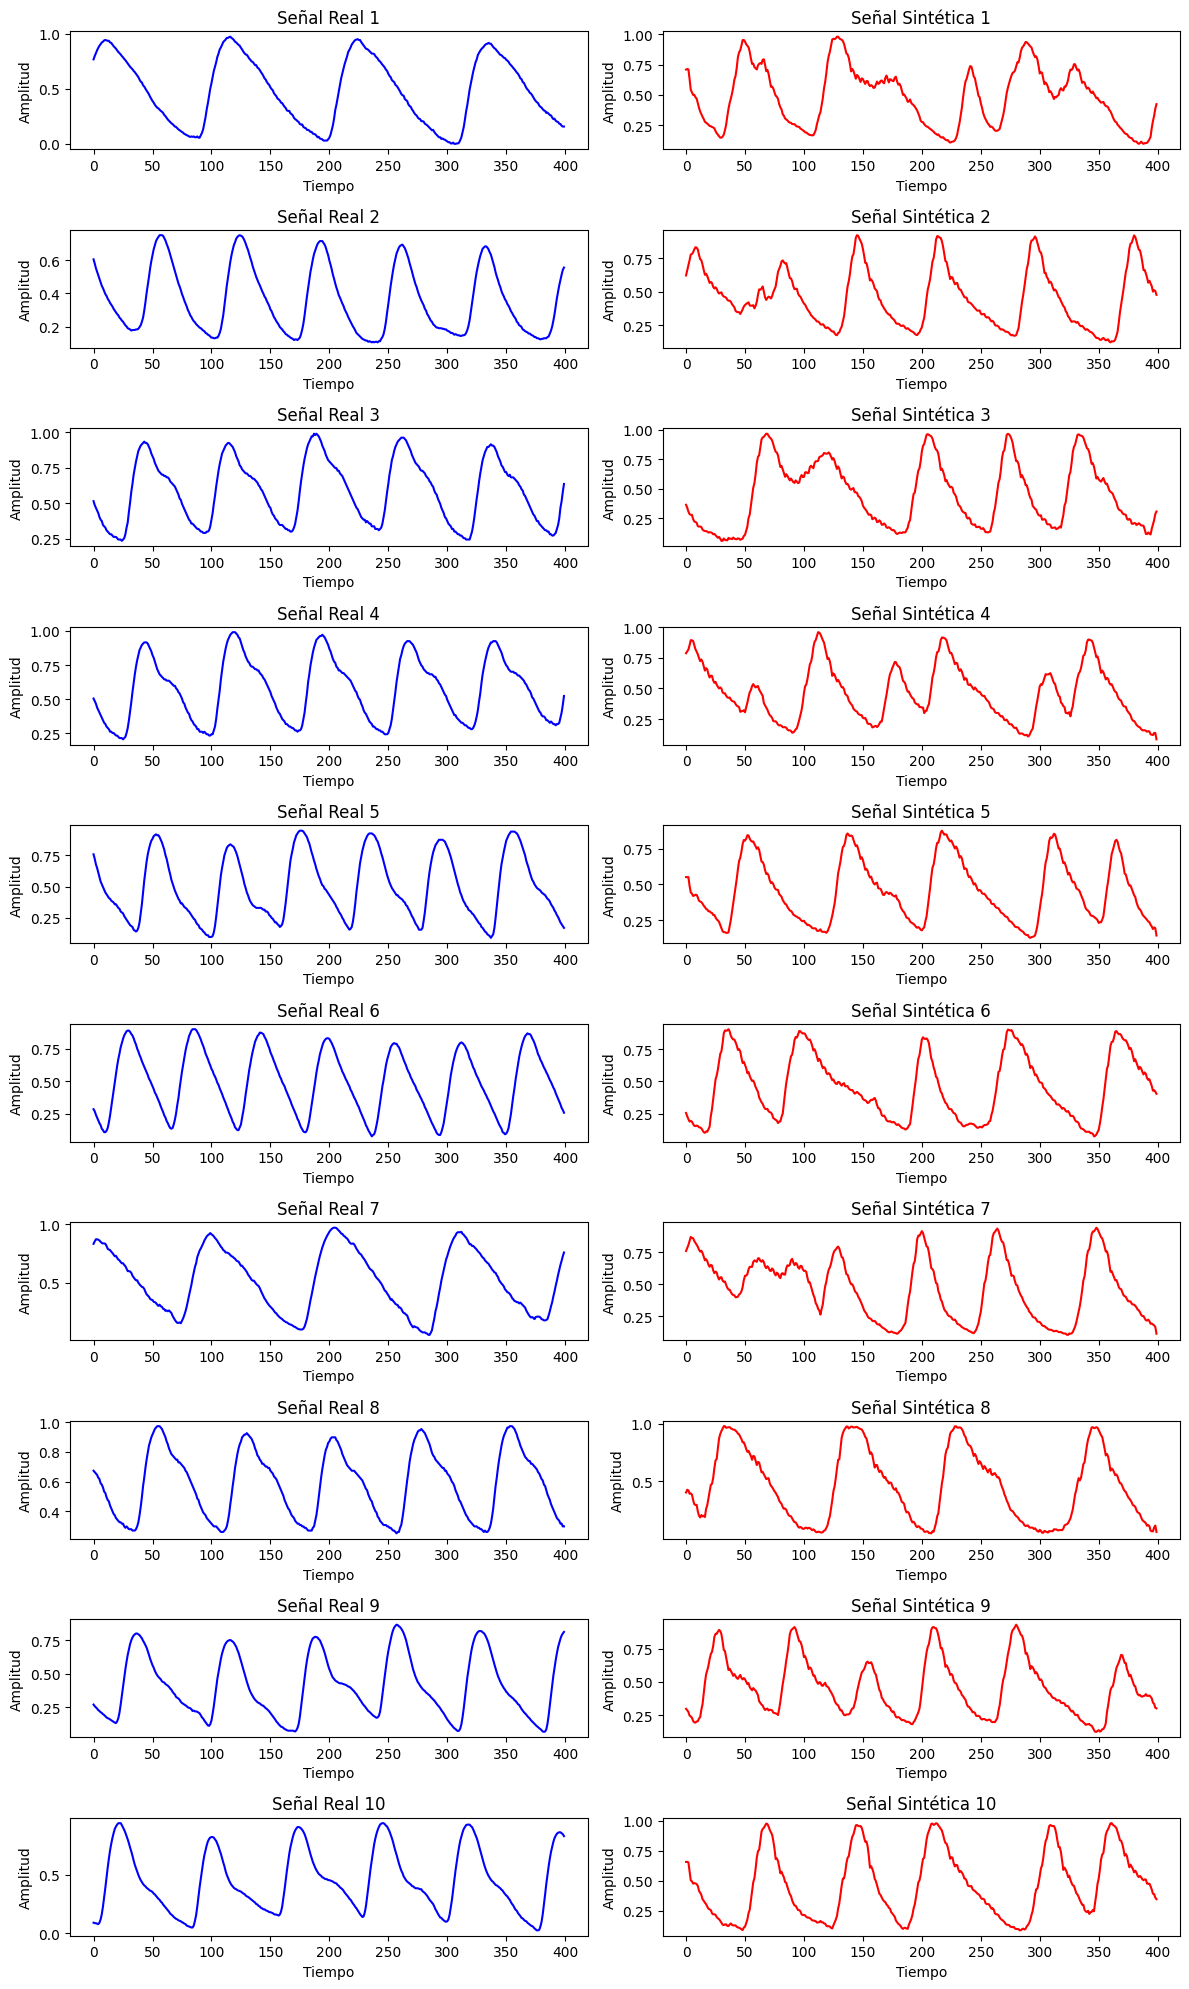

In [ ]:
plot_real_vs_synthetic(ppg_signals, synthetic_ppg_signals, num_samples=10)